<a href="https://colab.research.google.com/github/rigolivares/coderhouse/blob/main/ProyectoDS_ParteIII_Olivares_Paez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Análisis y Predicción de Ventas para una Empresa de Delivery

En este trabajo, nos enfocaremos en el análisis exhaustivo de una empresa de delivery, utilizando un dataset que proporciona información detallada sobre los pedidos realizados por los usuarios mensualmente. Además, el dataset incluye datos sobre los ingresos generados por la empresa en términos de órdenes. Un aspecto destacado de este análisis será el programa de fidelización conocido como "Plus".

Los objetivos principales de este estudio son dos:

1.   Evaluación del Impacto del Programa Plus: Analizaremos el impacto del programa de fidelización Plus en las ventas y la retención de clientes. La meta es demostrar que los usuarios suscritos al programa Plus son más beneficiosos para la empresa en comparación con los usuarios regulares.

2.   Predicción de Ventas Futuras: Utilizando técnicas de modelado y análisis de datos, buscaremos predecir las ventas futuras de la empresa. Esto permitirá a la empresa tomar decisiones informadas sobre estrategias de crecimiento y optimización de recursos.

Este análisis está basado en datos actualizados al 21 de mayo de 2024

In [1]:
#Importamos librerias importantes para el trabajo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import PercentFormatter
from google.colab import drive

from google.colab import data_table

import os
drive.mount('/content/drive')

# Colores personalizados que ire utilizando con los graphs
colors = ['#f52f41', '#00d9fc', '#ff8aff', '#ffd700' , '#ff6d01', '#cccccc' , '#008297']


Mounted at /content/drive


Importamos la bbdd y revisamos los tipos de datos de la importación.

In [89]:
# Definir la ruta del archivo
file_path = '/content/drive/My Drive/CODERHOUSE_Rigoberto_Olivares/proyecto_ds_01/bbdd_delivery.csv'

df = pd.read_csv(file_path)

# Mostrar las primeras filas del DataFrame
#print(df[['date_month','total_confirmed_order']].head())

df.head()

# Ver los tipos de datos de cada columna
print(df.dtypes)

date_month                         object
partner_area_name                  object
name_city                          object
zonas                              object
zonas_santiago                     object
vertical                           object
total_confirmed_order               int64
total_active_users                  int64
total_failed_order                  int64
total_failed_active_users           int64
total_confirmed_orders_plus         int64
total_plus_active_users             int64
total_failed_orders_plus            int64
total_failed_plus_active_users      int64
total_GFV                         float64
total_GFV_PLUS                    float64
total_GFV_NO_PLUS                 float64
total_GMV                         float64
total_GMV_PLUS                    float64
total_GMV_NO_PLUS                 float64
dtype: object


Basado en lo que vimos con la función dtypes en el código anterior cambiamos los tipo de datos de nuestro DF para poder trabajar correctamente con las variables. Especialmente las de fechas y las métricas que deben ser intengers.

In [90]:
# Convertir date_month a datetime
df['date_month'] = pd.to_datetime(df['date_month'], errors='coerce')

# Verificar y convertir todas las columnas que comienzan con 'total_' a int64
total_columns = [col for col in df.columns if col.startswith('total_')]

for col in total_columns:
    # Reemplazar NaN con 0 antes de la conversión
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Verificar las conversiones
print(df.dtypes)
df.head()


date_month                        datetime64[ns]
partner_area_name                         object
name_city                                 object
zonas                                     object
zonas_santiago                            object
vertical                                  object
total_confirmed_order                      int64
total_active_users                         int64
total_failed_order                         int64
total_failed_active_users                  int64
total_confirmed_orders_plus                int64
total_plus_active_users                    int64
total_failed_orders_plus                   int64
total_failed_plus_active_users             int64
total_GFV                                  int64
total_GFV_PLUS                             int64
total_GFV_NO_PLUS                          int64
total_GMV                                  int64
total_GMV_PLUS                             int64
total_GMV_NO_PLUS                          int64
dtype: object


,date_month,partner_area_name,name_city,zonas,zonas_santiago,vertical,total_confirmed_order,total_active_users,total_failed_order,total_failed_active_users,total_confirmed_orders_plus,total_plus_active_users,total_failed_orders_plus,total_failed_plus_active_users,total_GFV,total_GFV_PLUS,total_GFV_NO_PLUS,total_GMV,total_GMV_PLUS,total_GMV_NO_PLUS
0,2024-05-01,Linares,Linares,Sur,Regiones,food,10151,4683,218,196,897,257,19,257,121728918,9909936,111818982,133538654,10650448,122888206
1,2023-12-01,Talagante,Talagante,RM,Zona No Oriente,food,1788,1048,133,117,149,81,11,81,25115179,1949939,23165239,28188234,2112459,26075775
2,2021-05-01,LicanRay,Villarrica,other,Regiones,food,581,577,10,9,0,0,0,0,2684678,0,2684678,2699678,0,2699678
3,2023-01-01,Linares,Linares,Sur,Regiones,food,5570,2836,214,192,477,137,21,137,66401289,5393527,61007761,72650945,5622439,67028505
4,2022-08-01,Calle Larga,Los Andes,Quinta,Regiones,food,74,29,1,1,0,0,0,0,886697,0,886697,972135,0,972135


Ahora creamos nuestro DF monthly_sales para hacer el primer análisis exploratorio. Y también necesitamos hacer un par de ajustes a nuestro DF.

1. Renombrar algunos campos.
2. Calcular ciertas métricas imporantes para evaluar el programa de plus vs los usuarios no plus.
3. Cambiar los valores para las métricas plus anterior a enero 2022, ya que en el codigo anterior rellenamos esos NaaN con 0 para los calculos de las nuevas variables. Pero realmente deben ser NaaN para no alterar los primeros gráficos.

In [120]:
# Seleccionamos las variables que comienzan con el texto total_ que seran nuestras metricas de comparación entre usuarios dentro del programa y fuera del programa.
total_columns = [col for col in df.columns if col.startswith('total_')]

# Agrupamos por mes y sumamos las columnas que empiezan con 'total_'
monthly_sales = df.groupby('date_month')[total_columns].sum().reset_index()

# Convertimos 'date_month' a periodo mensual para tener un formato consistente
monthly_sales['date_month'] = pd.to_datetime(monthly_sales['date_month']).dt.to_period('M').dt.to_timestamp()

# Renombrar las columnas para mayor claridad
monthly_sales.rename(columns={
    'total_confirmed_order': 'total_orders',
    'total_confirmed_orders_plus': 'total_orders_plus'
}, inplace=True)


# Ahora voy a calcular ciertas kpi y metricas que nos serviran para ir comparando usuarios plus y usuarios que no son parte del programa.
monthly_sales['total_orders_non_plus'] = monthly_sales['total_orders'] - monthly_sales['total_orders_plus']
monthly_sales['total_GFV_NO_PLUS'] = (monthly_sales['total_GFV']-monthly_sales['total_GFV_PLUS'])
monthly_sales['total_non_plus_active_user'] = monthly_sales['total_active_users'] - monthly_sales['total_plus_active_users']
monthly_sales['total_failed_orders_non_plus'] = monthly_sales['total_failed_order'] - monthly_sales['total_failed_orders_plus']

monthly_sales['total_frequency_plus'] = round(monthly_sales['total_orders_plus']/ monthly_sales['total_plus_active_users'],2)
monthly_sales['total_frequency_non_plus'] = round(monthly_sales['total_orders_non_plus']/ monthly_sales['total_non_plus_active_user'],2)

monthly_sales['total_afv_plus'] = round(monthly_sales['total_GFV_PLUS']/ monthly_sales['total_orders_plus'],2)
monthly_sales['total_afv_non_plus'] = round(monthly_sales['total_GFV_NO_PLUS']/ monthly_sales['total_orders_non_plus'],2)

monthly_sales['total_fail_rate_plus'] = round(monthly_sales['total_failed_orders_plus']/ monthly_sales['total_orders_plus'],6)
monthly_sales['total_fail_rate_non_plus'] = round(monthly_sales['total_failed_orders_non_plus']/ monthly_sales['total_orders_non_plus'],6)


# Filtrar los datos para eliminar los valores de total_orders_plus antes de 2022-01 ya que el proyecto comenzo recién en ese periodo. por lo que para cada variable volvemos a transformar de 0 a naan para no estropear graficos
plus_to_nan = ['total_orders_plus', 'total_plus_active_users', 'total_failed_orders_plus', 'total_failed_plus_active_users', 'total_GFV_PLUS', 'total_GMV_PLUS']
monthly_sales.loc[monthly_sales['date_month'] < '2022-01-01', plus_to_nan] = np.nan


# Eliminamos el mes de mayo de 2024 ya que esta con data incompleta.
monthly_sales = monthly_sales[monthly_sales['date_month'] != pd.Timestamp('2024-05-01')]
monthly_sales = monthly_sales[monthly_sales['date_month'] != pd.Timestamp('2024-06-01')]

# Mostrar el resultado
monthly_sales.head()


,date_month,total_orders,total_active_users,total_failed_order,total_failed_active_users,total_orders_plus,total_plus_active_users,total_failed_orders_plus,total_failed_plus_active_users,total_GFV,...,total_GMV_NO_PLUS,total_orders_non_plus,total_non_plus_active_user,total_failed_orders_non_plus,total_frequency_plus,total_frequency_non_plus,total_afv_plus,total_afv_non_plus,total_fail_rate_plus,total_fail_rate_non_plus
0,2021-01-01,2048754,930172,139788,113499,NaN,NaN,NaN,NaN,24714772029,...,27325486701,2048754,930172,139788,NaN,2.20,NaN,12063.32,NaN,0.068231
1,2021-02-01,1857831,869235,102271,85251,NaN,NaN,NaN,NaN,22123758542,...,24325890653,1857831,869235,102271,NaN,2.14,NaN,11908.38,NaN,0.055049
2,2021-03-01,2244244,1017088,120063,99880,NaN,NaN,NaN,NaN,26372127173,...,28960066936,2244244,1017088,120063,NaN,2.21,NaN,11751.01,NaN,0.053498
3,2021-04-01,2298036,1011105,109719,91638,NaN,NaN,NaN,NaN,27956985293,...,30742526025,2298036,1011105,109719,NaN,2.27,NaN,12165.60,NaN,0.047745
4,2021-05-01,2543398,1127566,174569,143302,NaN,NaN,NaN,NaN,32322452575,...,35560272965,2543398,1127566,174569,NaN,2.26,NaN,12708.37,NaN,0.068636


Ahora pasaremos a graficar todo en el mismo codigo para ver la comparación de las metricas de manera mas simple.

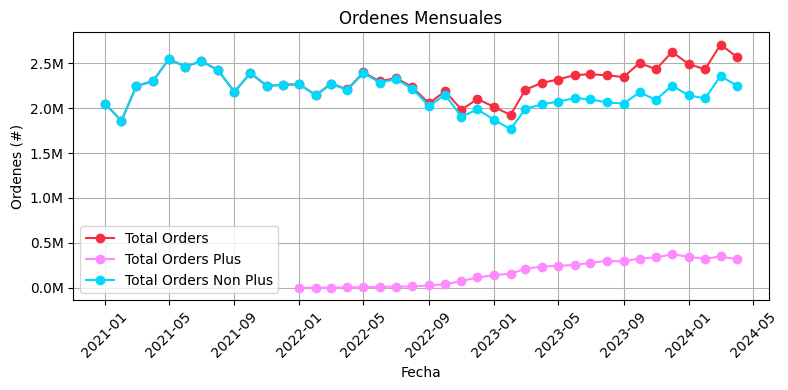

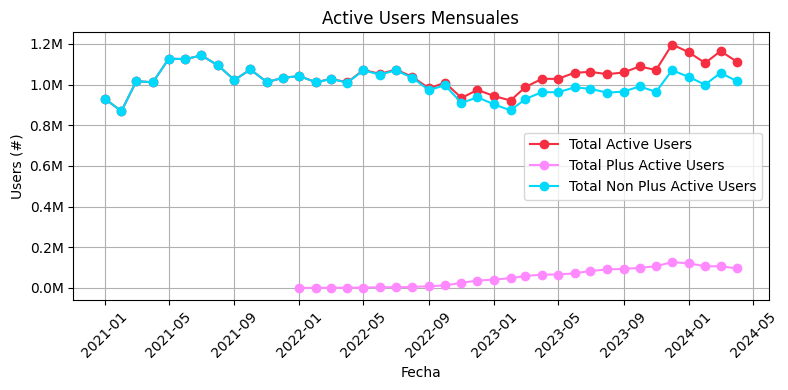

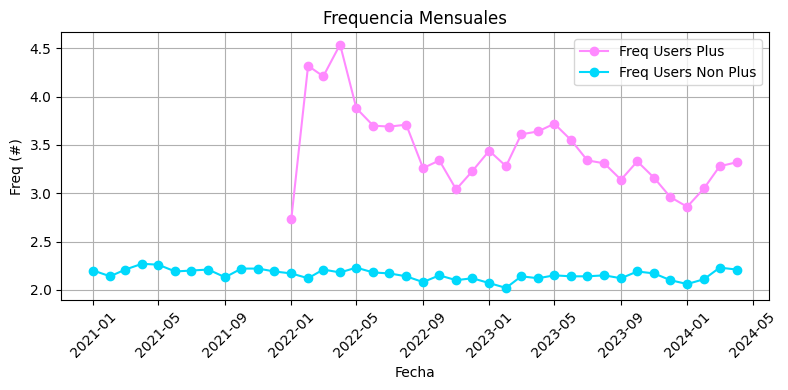

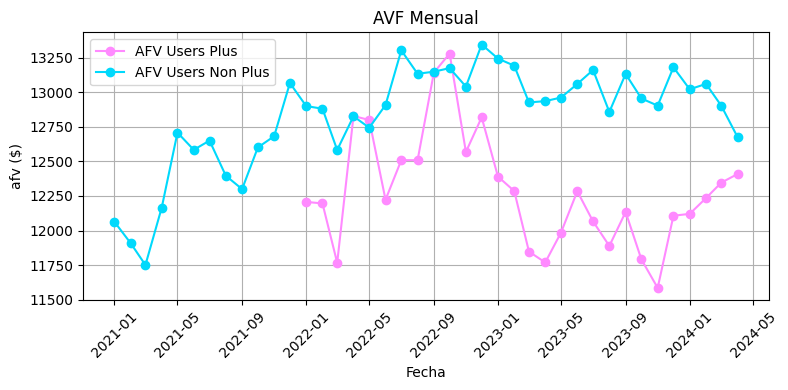

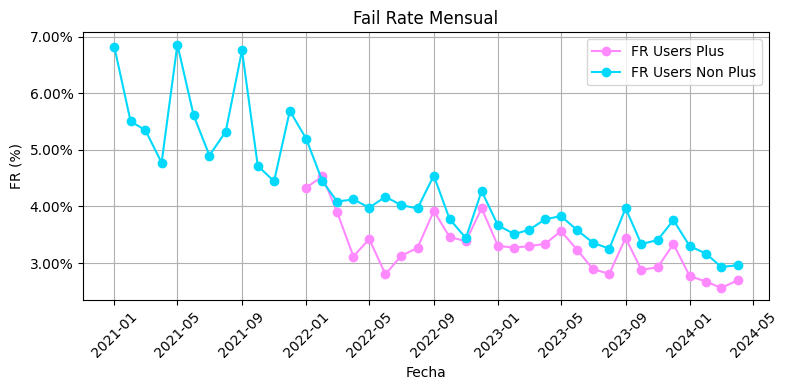

In [121]:
# Primero creamos el grafico de ordenes mensuales para ver la evolucón de estas y ver como irrumpe el programa a principios de 2022
plt.figure(figsize=(8, 4))
# Línea para total_confirmed_orders con el color deseado
plt.plot(monthly_sales['date_month'], monthly_sales['total_orders'], marker='o', label='Total Orders', color='#f52f41')
plt.plot(monthly_sales['date_month'], monthly_sales['total_orders_plus'], marker='o', label='Total Orders Plus', color='#ff8aff')
plt.plot(monthly_sales['date_month'], monthly_sales['total_orders_non_plus'], marker='o', label='Total Orders Non Plus', color='#00d9fc')
# Añadir títulos y etiquetas
plt.title('Ordenes Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ordenes (#)')
plt.legend()
plt.grid(True)
# Formatear el eje Y en millones y eliminar notación científica
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))
# Mostrar el gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ahora creamos el grafico mensual de los active user. Donde deberiamos tambien observar como irrumpe el programa a principios de 2022
plt.figure(figsize=(8, 4))
# Línea para total_active_user con el color deseado
plt.plot(monthly_sales['date_month'], monthly_sales['total_active_users'], marker='o', label='Total Active Users', color='#f52f41')
plt.plot(monthly_sales['date_month'], monthly_sales['total_plus_active_users'], marker='o', label='Total Plus Active Users', color='#ff8aff')
plt.plot(monthly_sales['date_month'], monthly_sales['total_non_plus_active_user'], marker='o', label='Total Non Plus Active Users', color='#00d9fc')
# Añadir títulos y etiquetas
plt.title('Active Users Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Users (#)')
plt.legend()
plt.grid(True)
# Formatear el eje Y en millones y eliminar notación científica
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))
# Mostrar el gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





# Crear el gráfico de líneas para frecuencia mensual de los usuarios. Para saber quien consume más mensualmente.
plt.figure(figsize=(8, 4))
# Línea para total_confirmed_orders con el color deseado
plt.plot(monthly_sales['date_month'], monthly_sales['total_frequency_plus'], marker='o', label='Freq Users Plus', color='#ff8aff')
plt.plot(monthly_sales['date_month'], monthly_sales['total_frequency_non_plus'], marker='o', label='Freq Users Non Plus', color='#00d9fc')
# Añadir títulos y etiquetas
plt.title('Frequencia Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Freq (#)')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Crear el gráfico de líneas para afv mensual. Lo que nos permite saber cuanto gasta un usuario por pedido.
plt.figure(figsize=(8, 4))
# Línea para total_confirmed_orders con el color deseado
plt.plot(monthly_sales['date_month'], monthly_sales['total_afv_plus'], marker='o', label='AFV Users Plus', color='#ff8aff')
plt.plot(monthly_sales['date_month'], monthly_sales['total_afv_non_plus'], marker='o', label='AFV Users Non Plus', color='#00d9fc')
# Añadir títulos y etiquetas
plt.title('AVF Mensual')
plt.xlabel('Fecha')
plt.ylabel('afv ($)')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# Finalmnete que tipo de usuario tiene una menor tasa de error o fallos en los pedidos.
plt.figure(figsize=(8, 4))
# Línea para total_confirmed_orders con el color deseado
plt.plot(monthly_sales['date_month'], monthly_sales['total_fail_rate_plus'], marker='o', label='FR Users Plus', color='#ff8aff')
plt.plot(monthly_sales['date_month'], monthly_sales['total_fail_rate_non_plus'], marker='o', label='FR Users Non Plus', color='#00d9fc')
# Añadir títulos y etiquetas
plt.title('Fail Rate Mensual')
plt.xlabel('Fecha')
plt.ylabel('FR (%)')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# Mostrar el gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ahora crearemos las tablas desde que comenzo el proyecto para ver los datos reales y las diferencias porcentuales.

In [122]:
# Calculamos los porcentajes de penetración del programa en termino de ordenes y active users para ver que tanto representan estas ordenes y usuarios del total de la compañia
monthly_sales['plus_penetration_orders'] = round(( monthly_sales['total_orders_plus']/monthly_sales['total_orders'])*100,2)
monthly_sales['plus_penetration_users'] = round((monthly_sales['total_plus_active_users']/monthly_sales['total_active_users'] )*100,2)

# Crear una nueva columna para la diferencia entre Plus y no Plus
monthly_sales['diff_%_frequency'] = round((monthly_sales['total_frequency_plus']/ monthly_sales['total_frequency_non_plus']-1)*100,2)
monthly_sales['diff_%_afv'] = round((monthly_sales['total_afv_plus']/ monthly_sales['total_afv_non_plus']-1)*100,2)


# Filtrar los datos desde enero de 2022 y cambiamos el formato para que cuando
# generemos la tabla se vea bien.

monthly_sales['date_month'] = pd.to_datetime(monthly_sales['date_month'])
filtered_sales = monthly_sales[monthly_sales['date_month'] >= '2022-01-01']


# Seleccionar las columnas deseadas
filtered_sales = filtered_sales[['date_month', 'total_orders', 'plus_penetration_orders','total_active_users','total_plus_active_users', 'plus_penetration_users', 'total_frequency_plus','total_frequency_non_plus','diff_%_frequency'
                ,'total_afv_plus','total_afv_non_plus','diff_%_afv']]
filtered_sales['date_month'] = filtered_sales['date_month'].dt.strftime('%Y-%b')

# Mostrar el resultado filtrado
data_table.DataTable(filtered_sales)

,date_month,total_orders,plus_penetration_orders,total_active_users,total_plus_active_users,plus_penetration_users,total_frequency_plus,total_frequency_non_plus,diff_%_frequency,total_afv_plus,total_afv_non_plus,diff_%_afv
12,2022-Jan,2262223,0.03,1041896,228.0,0.02,2.73,2.17,25.81,12207.40,12900.12,-5.37
13,2022-Feb,2142470,0.11,1011586,567.0,0.06,4.32,2.12,103.77,12196.12,12881.18,-5.32
14,2022-Mar,2271342,0.18,1028021,967.0,0.09,4.21,2.21,90.50,11766.83,12582.75,-6.48
15,2022-Apr,2208143,0.26,1011403,1273.0,0.13,4.54,2.18,108.26,12828.23,12826.25,0.02
16,2022-May,2395909,0.36,1071894,2212.0,0.21,3.88,2.23,73.99,12799.71,12743.79,0.44
17,2022-Jun,2294814,0.53,1052644,3275.0,0.31,3.70,2.18,69.72,12222.88,12907.68,-5.31
18,2022-Jul,2335390,0.62,1073705,3905.0,0.36,3.69,2.17,70.05,12509.33,13303.27,-5.97
19,2022-Aug,2230575,0.75,1037904,4499.0,0.43,3.71,2.14,73.36,12508.70,13133.86,-4.76
20,2022-Sep,2050905,1.38,981282,8697.0,0.89,3.26,2.08,56.73,13141.76,13148.84,-0.05
21,2022-Oct,2186657,1.85,1009450,12096.0,1.20,3.34,2.15,55.35,13280.17,13174.74,0.80


Primeras conclusiones:

1.   **Órdenes:** En términos de órdenes, observamos la aparición de pedidos de usuarios Plus en 2022. Esto podría implicar un incremento en las órdenes de la compañía. La penetración de ordenes plus del total de ordenes ha crecido constantmente hasta diciembre 2023. Ahi tiende a estancarse en torno al 13%, al igual que la penetración en terminos de usuario que en abril esta en torno al 7%.

2.  **Frecuencia mensual:** Podemos evaluar que la frecuencia mensual de los usuarios Plus es mayor. Este programa está dirigido a usuarios fieles a la app, por lo que era esperable que realizaran más pedidos. De esta manera, justifican el costo del programa con descuentos y envíos gratis. Además, notamos una caída significativa desde inicios de 2022 hasta mediados de 2023, donde comienza a estabilizarse. Esto coincide con un aumento en usuarios activos. Podemos suponer que los Early Adopters inicialmente aumentan esta frecuencia, y a medida que crece la base de usuarios del programa, tiende a estabilizarse, pero aún por encima de los usuarios no Plus. De hecho en abril la frecuencia fue un 85% mayor para plus.

3. **Valor promedio de los pedidos (AFV):** El Average Food Value o AFV es mayor para los usuarios No Plus. Esto puede deberse a que los miembros del programa Plus tienen acceso a descuentos exclusivos en la app, lo que resulta en pedidos más económicos. Aunque esta brecha se ha ido cerrando, de hecho en abril la diferncia para plus solo fue -2.11%
Sin embargo, aún falta calcular el gasto mensual por usuario. Dado que tenemos una mayor frecuencia de pedidos a un menor precio, esto podría traducirse en un mayor gasto total.

4. **Tasa de fallos (fail rate):** La tasa de fallos, es decir, órdenes canceladas o con errores en el envío, es mayor para los usuarios no Plus. Esto indica que el programa es más exitoso en el segmento Plus, ya que al pagar por una suscripción se espera un mejor servicio. Aun así, observamos una caída alrededor del 3% entre inicios de 2022 e inicios de 2024 para los no Plus, lo que también refleja una mejora en la logística de la empresa.


Para validar lo señalado en el punto 3, calcularemos el gasto mensual promedio por usuario para determinar si los usuarios del programa Plus gastan más mensualmente en comparación con los usuarios no Plus.

Definiremos el gasto mensual promedio como:
  AFV Mensual * Frequencia Mensual

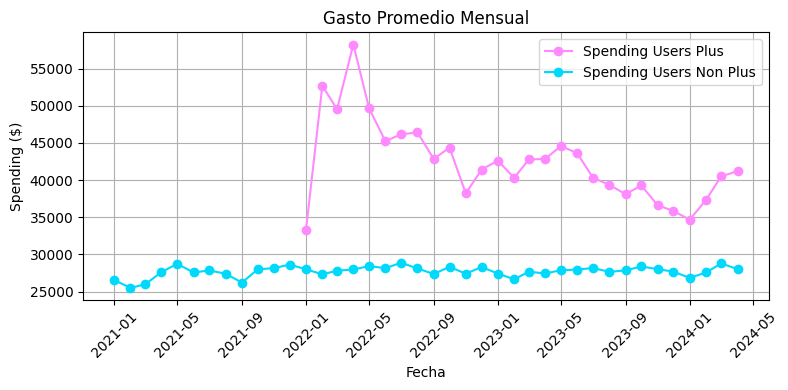

,date_month,monthly_spending_plus,monthly_spending_non_plus,spending_difference,spending_percentual_diff
12,2022-Jan,33326.0,27993.0,5333.0,19.05
13,2022-Feb,52687.0,27308.0,25379.0,92.94
14,2022-Mar,49538.0,27808.0,21730.0,78.14
15,2022-Apr,58240.0,27961.0,30279.0,108.29
16,2022-May,49663.0,28419.0,21244.0,74.75
17,2022-Jun,45225.0,28139.0,17086.0,60.72
18,2022-Jul,46159.0,28868.0,17291.0,59.90
19,2022-Aug,46407.0,28106.0,18301.0,65.11
20,2022-Sep,42842.0,27350.0,15492.0,56.64
21,2022-Oct,44356.0,28326.0,16030.0,56.59


In [130]:
# Calculamos el nuevo kpi de gasto mensual
monthly_sales['monthly_spending_plus'] = round(monthly_sales['total_afv_plus'] * monthly_sales['total_frequency_plus'])
monthly_sales['monthly_spending_non_plus'] = round(monthly_sales['total_afv_non_plus'] *  monthly_sales['total_frequency_non_plus'])
# Crear una nueva columna para la diferencia entre Plus y no Plus
monthly_sales['spending_difference'] = monthly_sales['monthly_spending_plus'] - monthly_sales['monthly_spending_non_plus']
monthly_sales['spending_percentual_diff'] = round((monthly_sales['monthly_spending_plus']/monthly_sales['monthly_spending_non_plus'] - 1)*100 ,2)



# Creamos el grafico del gasto mensual para comparar visualmente la diferencia de consumo
plt.figure(figsize=(8, 4))
# Línea para total_confirmed_orders con el color deseado
plt.plot(monthly_sales['date_month'], monthly_sales['monthly_spending_plus'], marker='o', label='Spending Users Plus', color='#ff8aff')
plt.plot(monthly_sales['date_month'], monthly_sales['monthly_spending_non_plus'], marker='o', label='Spending Users Non Plus', color='#00d9fc')
# Añadir títulos y etiquetas
plt.title('Gasto Promedio Mensual')
plt.xlabel('Fecha')
plt.ylabel('Spending ($)')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Filtrar los datos desde enero de 2022 y cambiamos el formato para que cuando
# generemos la tabla se vea bien.

monthly_sales['date_month'] = pd.to_datetime(monthly_sales['date_month'])
filtered_sales = monthly_sales[monthly_sales['date_month'] >= '2022-01-01']


# Seleccionar las columnas deseadas
filtered_sales = filtered_sales[['date_month', 'monthly_spending_plus', 'monthly_spending_non_plus', 'spending_difference', 'spending_percentual_diff']]
filtered_sales['date_month'] = filtered_sales['date_month'].dt.strftime('%Y-%b')

# Mostrar el resultado filtrado
data_table.DataTable(filtered_sales)



Por lo que somos capaces de apreciar en el gráfico efecivamente un usuario plus gasta más mensualmente que un usuario que no pertenece al programa, por lo que este es un usuario muy rentable. Ya que además hay que considerar que paga una subscripción mensual. En abril estaba gastando casi 16.300 pesos más mensualmente que un usuario no plus lo que significa un gasto 54.73% mayor.

---------------------------------------------------------------------------------------

Hemos realizado un análisis exploratorio en variables mensual pero aun queda comparar en dos/tres factors importantes. La zona del país, tipo de negocio y la vertical del negocio a la que pertenece.

En zonas tenemos 4 macro zonas:
*   Norte
*   5ta o Centro
*   RM
*   Sur

En las verticales tenemos la vertical de Food, Non food y DMART. Que se componen de los siguientes tipos de negocios:
*   Food: Restaurantes + Cafés
*   Non Food: Shop, Pets, Botillerias, Farmacias y el negocio de Courier
*   DMART: Markets exclusivos (subconjutno del tipo de negocio Markets)

Comenzamos realizando nuestro nuevo DF primero lo haremos con zonas.

In [139]:
# Nos aseguramos de que las columnas 'zonas' no tengan valores nulos
df['zonas'] = df['zonas'].fillna('Desconocido')

# Seleccionamos las variables que comienzan con el texto total_ que seran nuestras metricas de comparación entre usuarios dentro del programa y fuera del programa.
total_columns = [col for col in df.columns if col.startswith('total_')]
print("Total columns before renaming:", total_columns)

# Agrupamos por mes y sumamos las columnas que empiezan con 'total_'
zonas_monthly_sales = df.groupby([df['date_month'].dt.to_period('M'), 'zonas'])[total_columns].sum().reset_index()

# Renombrar las columnas para mayor claridad
zonas_monthly_sales.rename(columns={
    'total_confirmed_order': 'total_orders',
    'total_confirmed_orders_plus': 'total_orders_plus'
}, inplace=True)
print("Columns after renaming:", zonas_monthly_sales.columns)

# Ahora voy a calcular ciertas kpi y métricas que nos servirán para ir comparando usuarios plus y usuarios que no son parte del programa.
zonas_monthly_sales['total_orders_non_plus'] = zonas_monthly_sales['total_orders'] - zonas_monthly_sales['total_orders_plus']
zonas_monthly_sales['total_GFV_NO_PLUS'] = zonas_monthly_sales['total_GFV'] - zonas_monthly_sales['total_GFV_PLUS']
zonas_monthly_sales['total_non_plus_active_user'] = zonas_monthly_sales['total_active_users'] - zonas_monthly_sales['total_plus_active_users']
zonas_monthly_sales['total_failed_orders_non_plus'] = zonas_monthly_sales['total_failed_order'] - zonas_monthly_sales['total_failed_orders_plus']

zonas_monthly_sales['total_frequency_plus'] = round(zonas_monthly_sales['total_orders_plus'] / zonas_monthly_sales['total_plus_active_users'], 2)
zonas_monthly_sales['total_frequency_non_plus'] = round(zonas_monthly_sales['total_orders_non_plus'] / zonas_monthly_sales['total_non_plus_active_user'], 2)

zonas_monthly_sales['total_afv_plus'] = round(zonas_monthly_sales['total_GFV_PLUS'] / zonas_monthly_sales['total_orders_plus'], 2)
zonas_monthly_sales['total_afv_non_plus'] = round(zonas_monthly_sales['total_GFV_NO_PLUS'] / zonas_monthly_sales['total_orders_non_plus'], 2)

zonas_monthly_sales['total_fail_rate_plus'] = round(zonas_monthly_sales['total_failed_orders_plus'] / zonas_monthly_sales['total_orders_plus'], 6)
zonas_monthly_sales['total_fail_rate_non_plus'] = round(zonas_monthly_sales['total_failed_orders_non_plus'] / zonas_monthly_sales['total_orders_non_plus'], 6)

# Filtrar los datos para eliminar los valores de total_orders_plus antes de 2022-01 ya que el proyecto comenzó recién en ese periodo. por lo que para cada variable volvemos a transformar de 0 a NaN para no estropear gráficos
plus_to_nan = ['total_orders_plus', 'total_plus_active_users', 'total_failed_orders_plus', 'total_failed_plus_active_users', 'total_GFV_PLUS', 'total_GMV_PLUS']
zonas_monthly_sales.loc[zonas_monthly_sales['date_month'] < '2022-01-01', plus_to_nan] = np.nan

# Eliminamos el mes de mayo de 2024 ya que está con datos incompletos.
zonas_monthly_sales = zonas_monthly_sales[zonas_monthly_sales['date_month'] != pd.Timestamp('2024-05-01')]

# Verificar y convertir todas las columnas que comienzan con 'total_' a int64
total_columns = [col for col in zonas_monthly_sales.columns if col.startswith('total_')]
print("Total columns after all processing:", total_columns)

for col in total_columns:
    # Reemplazar NaN con 0 antes de la conversión
    zonas_monthly_sales[col] = pd.to_numeric(zonas_monthly_sales[col], errors='coerce').fillna(0).astype(int)

# Mostrar el resultado
print(zonas_monthly_sales.head())


Total columns before renaming: ['total_confirmed_order', 'total_active_users', 'total_failed_order', 'total_failed_active_users', 'total_confirmed_orders_plus', 'total_plus_active_users', 'total_failed_orders_plus', 'total_failed_plus_active_users', 'total_GFV', 'total_GFV_PLUS', 'total_GFV_NO_PLUS', 'total_GMV', 'total_GMV_PLUS', 'total_GMV_NO_PLUS']
Columns after renaming: Index(['date_month', 'zonas', 'total_orders', 'total_active_users',
       'total_failed_order', 'total_failed_active_users', 'total_orders_plus',
       'total_plus_active_users', 'total_failed_orders_plus',
       'total_failed_plus_active_users', 'total_GFV', 'total_GFV_PLUS',
       'total_GFV_NO_PLUS', 'total_GMV', 'total_GMV_PLUS',
       'total_GMV_NO_PLUS'],
      dtype='object')
Total columns after all processing: ['total_orders', 'total_active_users', 'total_failed_order', 'total_failed_active_users', 'total_orders_plus', 'total_plus_active_users', 'total_failed_orders_plus', 'total_failed_plus_active_use

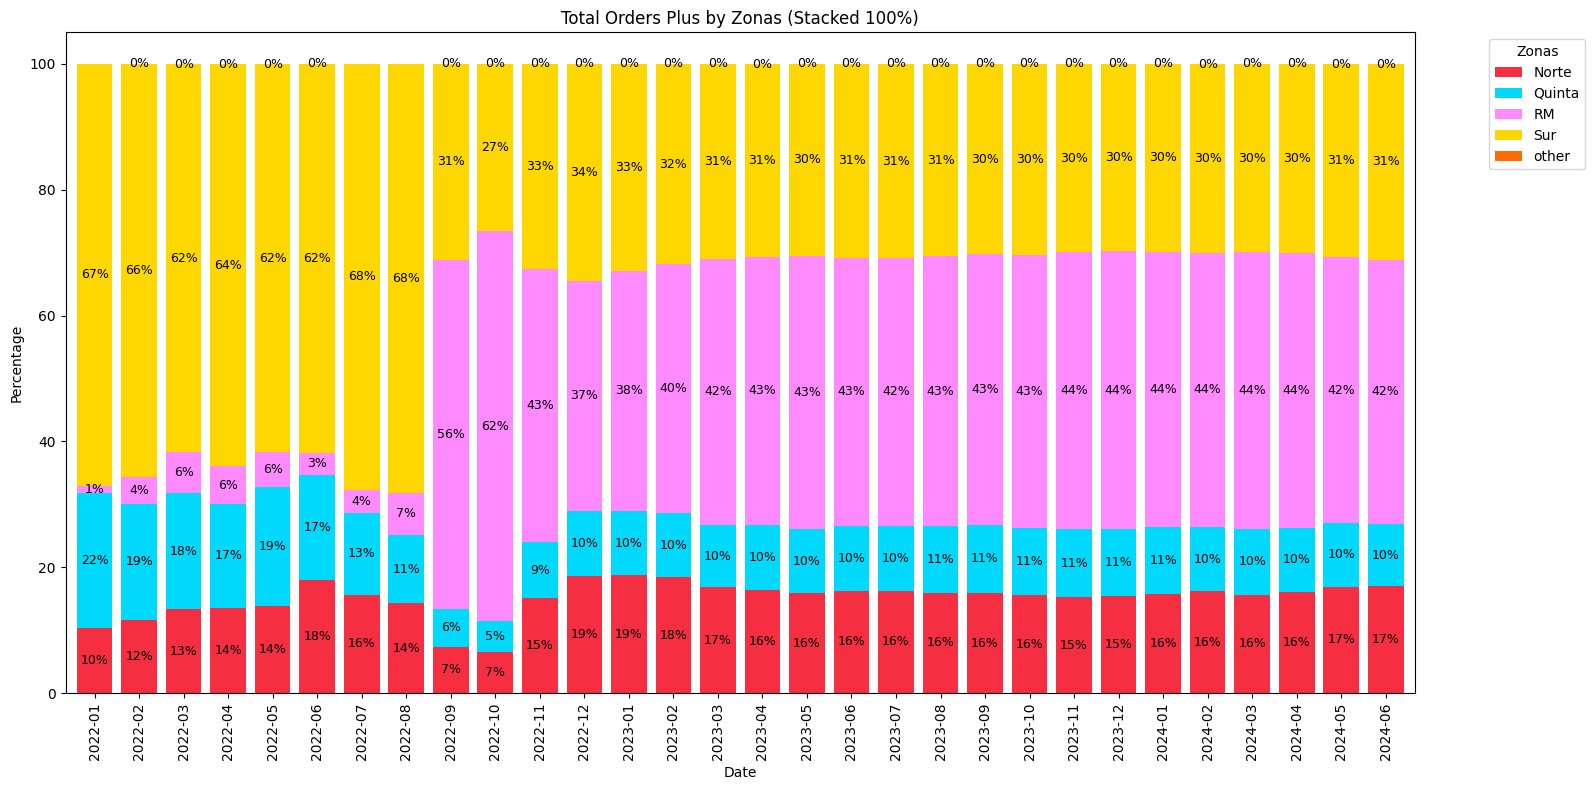

,Norte,Quinta,RM,Sur,other,Norte_percentage,Quinta_percentage,RM_percentage,Sur_percentage,other_percentage
date_month,,,,,,,,,,
2022-01,64,134,7,418,0,10.272873,21.508828,1.123596,67.094703,0.000000
2022-02,284,454,105,1606,1,11.591837,18.530612,4.285714,65.551020,0.040816
2022-03,544,751,264,2512,4,13.349693,18.429448,6.478528,61.644172,0.098160
2022-04,781,956,347,3688,6,13.516788,16.545517,6.005538,63.828314,0.103842
2022-05,1194,1620,478,5283,7,13.912841,18.876719,5.569797,61.559077,0.081566
2022-06,2173,2028,422,7474,5,17.955710,16.757561,3.487027,61.758387,0.041315
2022-07,2257,1875,529,9751,0,15.660561,13.009992,3.670552,67.658895,0.000000
2022-08,2374,1810,1129,11361,0,14.237735,10.855224,6.771021,68.136020,0.000000
2022-09,2085,1699,15743,8819,15,7.351645,5.990621,55.509326,31.095518,0.052890


In [151]:
# Filtrar los datos para tener solo las filas donde 'date_month' es mayor a '2022-01' que fue cuando comenzo el programa

filtered_data = zonas_monthly_sales[zonas_monthly_sales['date_month'] >= pd.Period('2022-01', freq='M')]

# Pivotar los datos para tener 'date_month' como índice y 'zonas' como columnas
pivot_data = filtered_data.pivot(index='date_month', columns='zonas', values='total_orders_plus')


## Normalizar los datos para obtener porcentajes
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Crear el gráfico de barras apiladas al 100%
ax = pivot_data_percentage.plot(kind='bar', stacked=True, color=colors, figsize=(16, 8), width=0.8,)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('Total Orders Plus by Zonas (Stacked 100%)')
plt.legend(title='Zonas', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadir los porcentajes en cada zona del gráfico
for n, x in enumerate([*pivot_data_percentage.index.values]):
    for (proportion, y_loc) in zip(pivot_data_percentage.loc[x], (pivot_data_percentage.cumsum(axis=1).loc[x] - pivot_data_percentage.loc[x] / 2)):
        if proportion > 0:
            ax.text(n, y_loc, f'{proportion:.0f}%', ha='center', va='center', color='black', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Crear una tabla con la visibilidad de las órdenes por zonas y el porcentaje que representa en cada mes
visibility_table = pivot_data_percentage.copy()
visibility_table.columns = [f'{col}_percentage' for col in visibility_table.columns]

# Unir las tablas para tener las órdenes y los porcentajes juntos
combined_table = pivot_data.join(visibility_table)

# Mostrar la tabla en Google Colab
combined_table

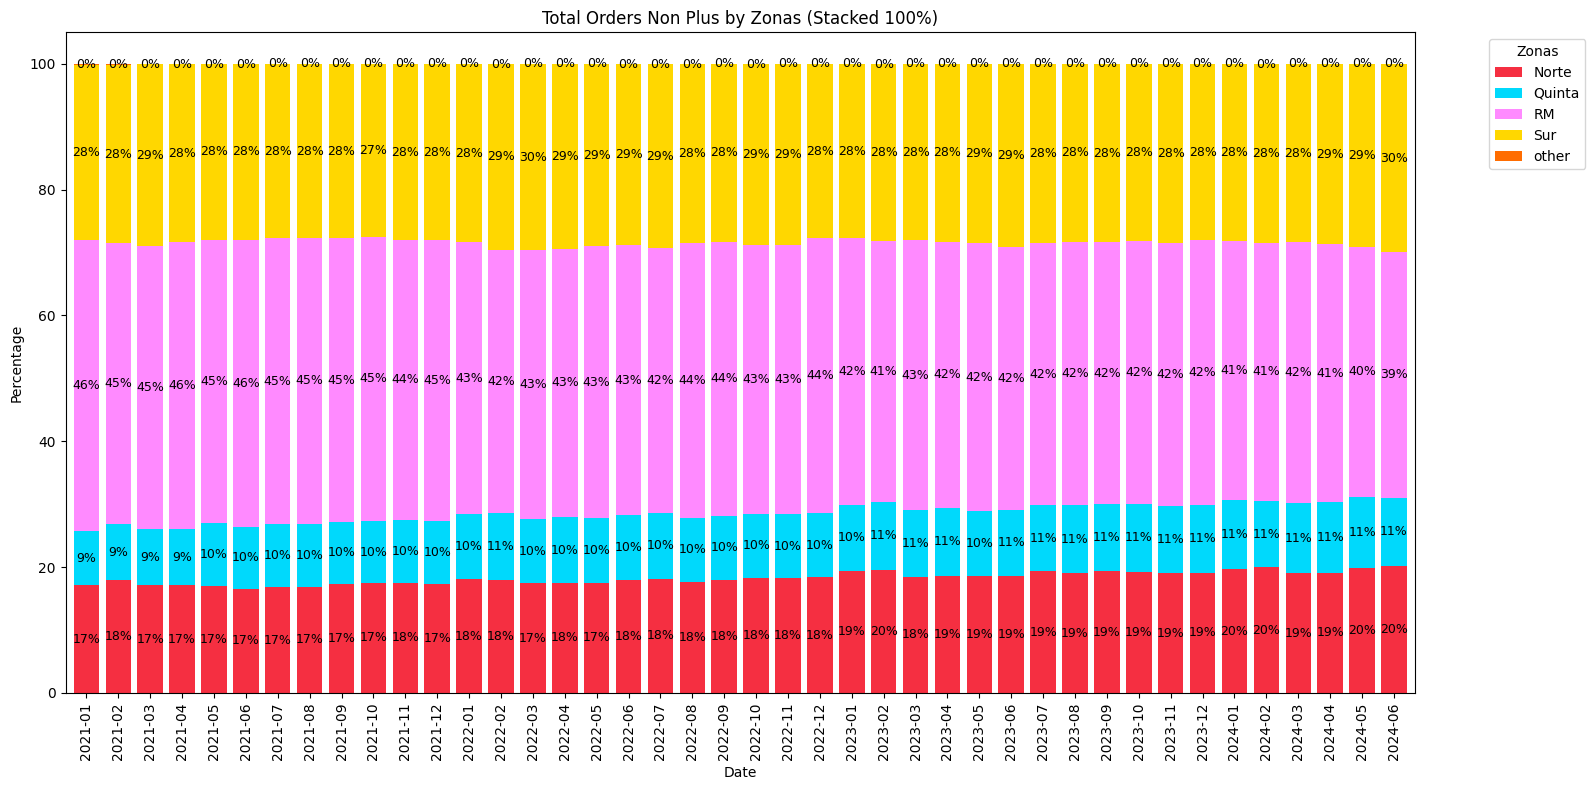

,Norte,Quinta,RM,Sur,other,Norte_percentage,Quinta_percentage,RM_percentage,Sur_percentage,other_percentage
date_month,,,,,,,,,,
2021-01,350264,176417,949465,569492,3116,17.096440,8.610941,46.343534,27.796993,0.152092
2021-02,332571,165793,830382,525434,3651,17.901036,8.924009,44.696315,28.282120,0.196519
2021-03,384266,200127,1010349,647596,1906,17.122292,8.917346,45.019570,28.855864,0.084928
2021-04,394129,204644,1047770,649515,1978,17.150689,8.905169,45.594151,28.263918,0.086073
2021-05,430939,254564,1147106,709038,1751,16.943436,10.008815,45.101317,27.877587,0.068845
2021-06,408100,240426,1124645,685761,1626,16.585669,9.771198,45.706909,27.870142,0.066083
2021-07,423109,252780,1145398,697659,1543,16.786782,10.029006,45.443483,27.679510,0.061218
2021-08,409743,241474,1099711,669635,1299,16.918511,9.970593,45.407666,27.649594,0.053636
2021-09,377800,215185,982135,603387,1288,17.331905,9.871800,45.056301,27.680906,0.059088


In [132]:
# Pivotar los datos para tener 'date_month' como índice y 'zonas' como columnas
pivot_data = zonas_monthly_sales.pivot(index='date_month', columns='zonas', values='total_orders_non_plus')

## Normalizar los datos para obtener porcentajes
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Crear el gráfico de barras apiladas al 100%
ax = pivot_data_percentage.plot(kind='bar', stacked=True, color=colors, figsize=(16, 8), width=0.8,)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('Total Orders Non Plus by Zonas (Stacked 100%)')
plt.legend(title='Zonas', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadir los porcentajes en cada zona del gráfico
for n, x in enumerate([*pivot_data_percentage.index.values]):
    for (proportion, y_loc) in zip(pivot_data_percentage.loc[x], (pivot_data_percentage.cumsum(axis=1).loc[x] - pivot_data_percentage.loc[x] / 2)):
        if proportion > 0:
            ax.text(n, y_loc, f'{proportion:.0f}%', ha='center', va='center', color='black', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Crear una tabla con la visibilidad de las órdenes por zonas y el porcentaje que representa en cada mes
visibility_table = pivot_data_percentage.copy()
visibility_table.columns = [f'{col}_percentage' for col in visibility_table.columns]

# Unir las tablas para tener las órdenes y los porcentajes juntos
combined_table = pivot_data.join(visibility_table)

# Mostrar la tabla en Google Colab
combined_table

Ahora calcularemos la frecuencia y afv del 2024 por zonas. agruparemos los datos para no verlo como serie temporal.

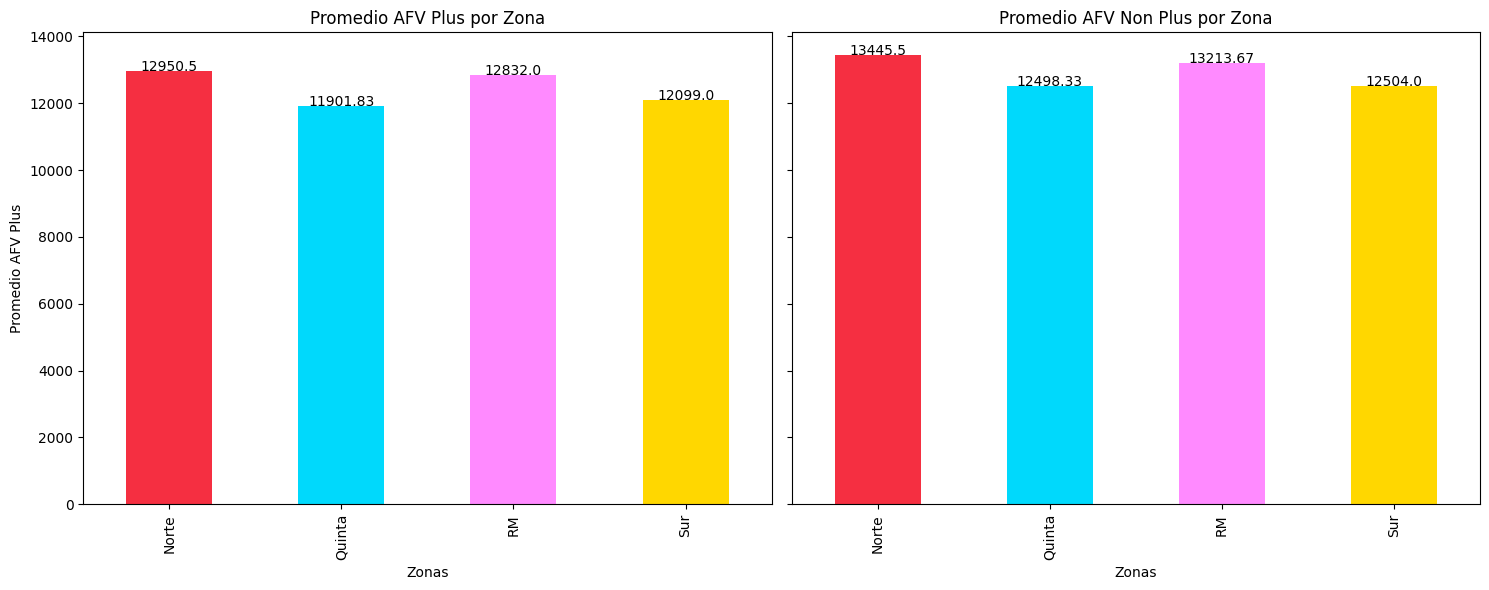

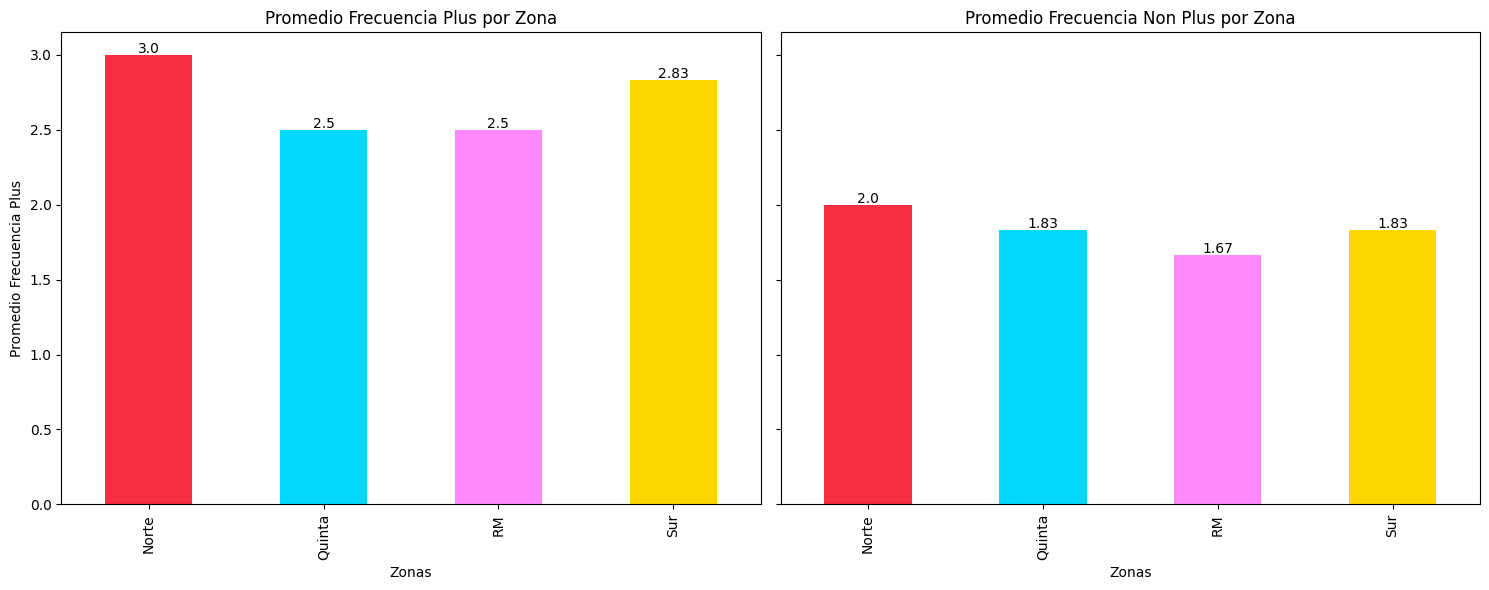

In [146]:

# Filtrar el DataFrame desde enero 2024 en adelante

df_filtered= zonas_monthly_sales[zonas_monthly_sales['date_month'] >= pd.Period('2024-01', freq='M')]
df_filtered = df_filtered[df_filtered['zonas'] != 'other']


# Crear el gráfico de barras para total_afv_plus y total_afv_non_plus por zonas
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Total afv plus
df_grouped_plus = df_filtered.groupby('zonas')['total_afv_plus'].mean()
df_grouped_plus.plot(kind='bar', ax=ax[0], color=colors)
ax[0].set_title('Promedio AFV Plus por Zona')
ax[0].set_xlabel('Zonas')
ax[0].set_ylabel('Promedio AFV Plus')
for i in ax[0].patches:
    ax[0].text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center', color='black')

# Total afv non plus
df_grouped_non_plus = df_filtered.groupby('zonas')['total_afv_non_plus'].mean()
df_grouped_non_plus.plot(kind='bar', ax=ax[1], color=colors)
ax[1].set_title('Promedio AFV Non Plus por Zona')
ax[1].set_xlabel('Zonas')
for i in ax[1].patches:
    ax[1].text(i.get_x() + i.get_width() / 2, i.get_height() + 0., round(i.get_height(), 2), ha='center', color='black')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Crear el gráfico de barras para total_frequency_plus y total_frequency_non_plus por zonas
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Total frequency plus
df_grouped_frequency_plus = df_filtered.groupby('zonas')['total_frequency_plus'].mean()
df_grouped_frequency_plus.plot(kind='bar', ax=ax[0], color=colors)
ax[0].set_title('Promedio Frecuencia Plus por Zona')
ax[0].set_xlabel('Zonas')
ax[0].set_ylabel('Promedio Frecuencia Plus')
for i in ax[0].patches:
    ax[0].text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center', color='black')

# Total frequency non plus
df_grouped_frequency_non_plus = df_filtered.groupby('zonas')['total_frequency_non_plus'].mean()
df_grouped_frequency_non_plus.plot(kind='bar', ax=ax[1], color=colors)
ax[1].set_title('Promedio Frecuencia Non Plus por Zona')
ax[1].set_xlabel('Zonas')
for i in ax[1].patches:
    ax[1].text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center', color='black')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Primera Conclusión de las zonas. Vemos que las ordenes se distribuyen de la misma forma por zonas en el total que en plus. La unica diferencia marginal es que. Norte tiene en torno de 2-3% menos que el total pais. Porcentajes que son distribuidos entre el sur y la RM. En el caso de la quinta se mantiene estable.

Cuando revisamos el afv por zonas notamos que si bien el norte es el tercero en penetración es el mayor em afv seguido por rm, sur y 5ta.
Y tambien notamos que terminos de frecuencia el sur si bien es el tercero en afv es el segundo mayor en frecuencia. Siendo el orden norte sur, rm y quinta.

In [ ]:
Ahora pasamos a hacer el mismo ejercicio por vertical.

In [147]:
# Nos aseguramos de que las columnas 'zonas' no tengan valores nulos
df['vertical'] = df['vertical'].fillna('Desconocido')

# Seleccionamos las variables que comienzan con el texto total_ que seran nuestras metricas de comparación entre usuarios dentro del programa y fuera del programa.
total_columns = [col for col in df.columns if col.startswith('total_')]
print("Total columns before renaming:", total_columns)

# Agrupamos por mes y sumamos las columnas que empiezan con 'total_'
vertical_monthly_sales = df.groupby([df['date_month'].dt.to_period('M'), 'vertical'])[total_columns].sum().reset_index()

# Renombrar las columnas para mayor claridad
vertical_monthly_sales.rename(columns={
    'total_confirmed_order': 'total_orders',
    'total_confirmed_orders_plus': 'total_orders_plus'
}, inplace=True)
print("Columns after renaming:", vertical_monthly_sales.columns)

# Ahora voy a calcular ciertas kpi y métricas que nos servirán para ir comparando usuarios plus y usuarios que no son parte del programa.
vertical_monthly_sales['total_orders_non_plus'] = vertical_monthly_sales['total_orders'] - vertical_monthly_sales['total_orders_plus']
vertical_monthly_sales['total_GFV_NO_PLUS'] = vertical_monthly_sales['total_GFV'] - vertical_monthly_sales['total_GFV_PLUS']
vertical_monthly_sales['total_non_plus_active_user'] = vertical_monthly_sales['total_active_users'] - vertical_monthly_sales['total_plus_active_users']
vertical_monthly_sales['total_failed_orders_non_plus'] = vertical_monthly_sales['total_failed_order'] - vertical_monthly_sales['total_failed_orders_plus']

vertical_monthly_sales['total_frequency_plus'] = round(vertical_monthly_sales['total_orders_plus'] / vertical_monthly_sales['total_plus_active_users'], 2)
vertical_monthly_sales['total_frequency_non_plus'] = round(vertical_monthly_sales['total_orders_non_plus'] / vertical_monthly_sales['total_non_plus_active_user'], 2)

vertical_monthly_sales['total_afv_plus'] = round(vertical_monthly_sales['total_GFV_PLUS'] / vertical_monthly_sales['total_orders_plus'], 2)
vertical_monthly_sales['total_afv_non_plus'] = round(vertical_monthly_sales['total_GFV_NO_PLUS'] / vertical_monthly_sales['total_orders_non_plus'], 2)

vertical_monthly_sales['total_fail_rate_plus'] = round(vertical_monthly_sales['total_failed_orders_plus'] / vertical_monthly_sales['total_orders_plus'], 6)
vertical_monthly_sales['total_fail_rate_non_plus'] = round(vertical_monthly_sales['total_failed_orders_non_plus'] / vertical_monthly_sales['total_orders_non_plus'], 6)

# Filtrar los datos para eliminar los valores de total_orders_plus antes de 2022-01 ya que el proyecto comenzó recién en ese periodo. por lo que para cada variable volvemos a transformar de 0 a NaN para no estropear gráficos
plus_to_nan = ['total_orders_plus', 'total_plus_active_users', 'total_failed_orders_plus', 'total_failed_plus_active_users', 'total_GFV_PLUS', 'total_GMV_PLUS']
vertical_monthly_sales.loc[vertical_monthly_sales['date_month'] < '2022-01-01', plus_to_nan] = np.nan

# Eliminamos el mes de mayo de 2024 ya que está con datos incompletos.
vertical_monthly_sales = vertical_monthly_sales[vertical_monthly_sales['date_month'] != pd.Timestamp('2024-05-01')]

# Verificar y convertir todas las columnas que comienzan con 'total_' a int64
total_columns = [col for col in vertical_monthly_sales.columns if col.startswith('total_')]
print("Total columns after all processing:", total_columns)

for col in total_columns:
    # Reemplazar NaN con 0 antes de la conversión
    vertical_monthly_sales[col] = pd.to_numeric(vertical_monthly_sales[col], errors='coerce').fillna(0).astype(int)

# Mostrar el resultado
print(vertical_monthly_sales.head())
print(vertical_monthly_sales.dtypes)


Total columns before renaming: ['total_confirmed_order', 'total_active_users', 'total_failed_order', 'total_failed_active_users', 'total_confirmed_orders_plus', 'total_plus_active_users', 'total_failed_orders_plus', 'total_failed_plus_active_users', 'total_GFV', 'total_GFV_PLUS', 'total_GFV_NO_PLUS', 'total_GMV', 'total_GMV_PLUS', 'total_GMV_NO_PLUS']
Columns after renaming: Index(['date_month', 'vertical', 'total_orders', 'total_active_users',
       'total_failed_order', 'total_failed_active_users', 'total_orders_plus',
       'total_plus_active_users', 'total_failed_orders_plus',
       'total_failed_plus_active_users', 'total_GFV', 'total_GFV_PLUS',
       'total_GFV_NO_PLUS', 'total_GMV', 'total_GMV_PLUS',
       'total_GMV_NO_PLUS'],
      dtype='object')
Total columns after all processing: ['total_orders', 'total_active_users', 'total_failed_order', 'total_failed_active_users', 'total_orders_plus', 'total_plus_active_users', 'total_failed_orders_plus', 'total_failed_plus_active_

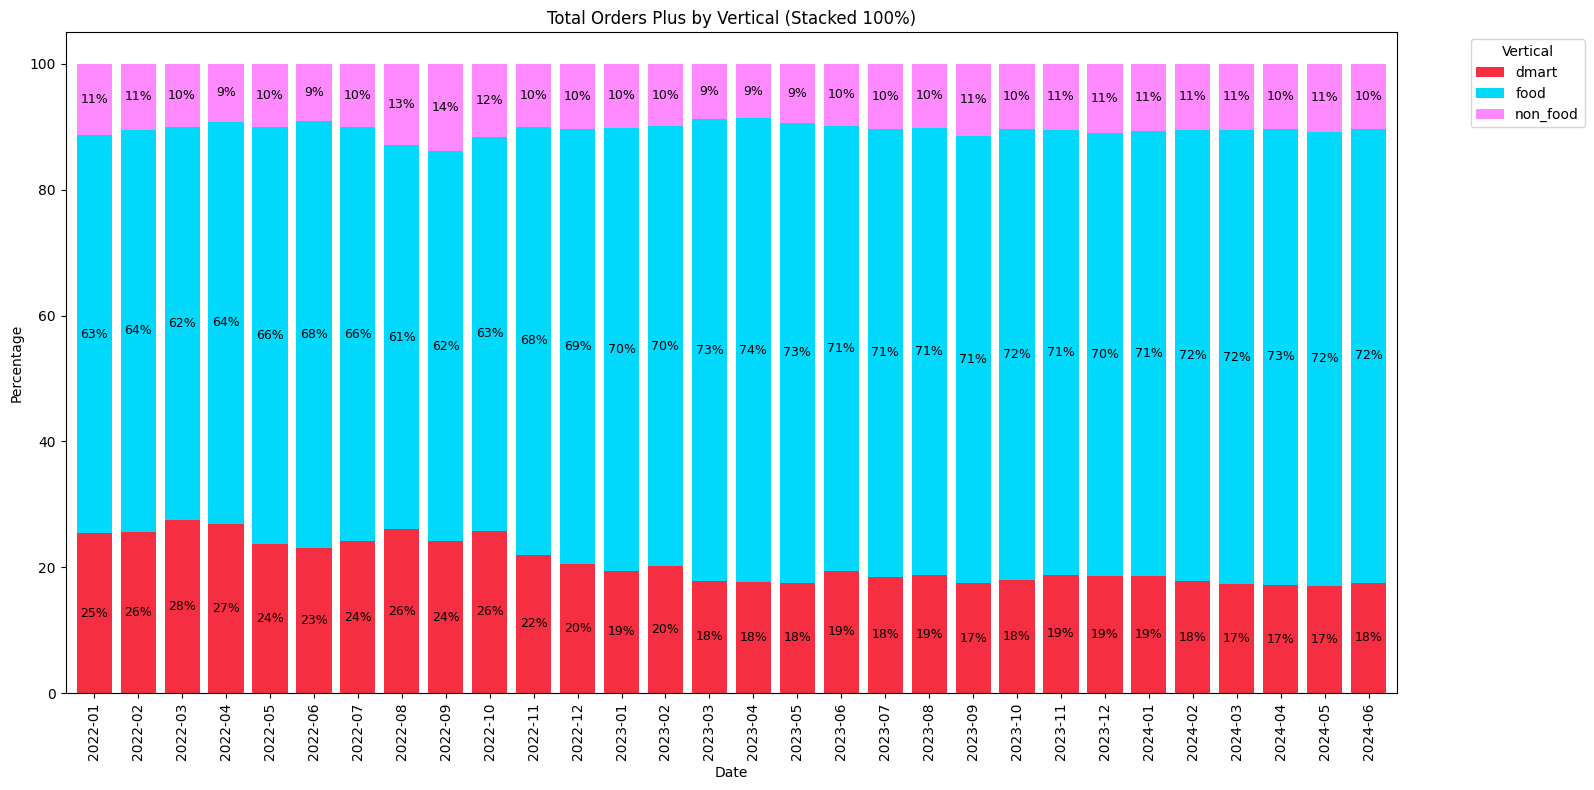

,dmart,food,non_food,dmart_percentage,food_percentage,non_food_percentage
date_month,,,,,,
2022-01,158,395,70,25.361156,63.402889,11.235955
2022-02,628,1564,258,25.632653,63.836735,10.530612
2022-03,1122,2543,410,27.533742,62.404908,10.061350
2022-04,1554,3689,535,26.895119,63.845621,9.259259
2022-05,2034,5681,867,23.700769,66.196691,10.102540
2022-06,2799,8207,1096,23.128409,67.815237,9.056354
2022-07,3482,9478,1452,24.160422,65.764641,10.074938
2022-08,4336,10184,2154,26.004558,61.077126,12.918316
2022-09,6842,17574,3945,24.124678,61.965375,13.909947


In [154]:
# Filtrar los datos para tener solo las filas donde 'date_month' es mayor a '2022-01' que fue cuando comenzo el programa

filtered_data = vertical_monthly_sales[vertical_monthly_sales['date_month'] >= pd.Period('2022-01', freq='M')]

# Pivotar los datos para tener 'date_month' como índice y 'vertical' como columnas
pivot_data = filtered_data.pivot(index='date_month', columns='vertical', values='total_orders_plus')


## Normalizar los datos para obtener porcentajes
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Crear el gráfico de barras apiladas al 100%
ax = pivot_data_percentage.plot(kind='bar', stacked=True, color=colors, figsize=(16, 8), width=0.8,)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('Total Orders Plus by Vertical (Stacked 100%)')
plt.legend(title='Vertical', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadir los porcentajes en cada zona del gráfico
for n, x in enumerate([*pivot_data_percentage.index.values]):
    for (proportion, y_loc) in zip(pivot_data_percentage.loc[x], (pivot_data_percentage.cumsum(axis=1).loc[x] - pivot_data_percentage.loc[x] / 2)):
        if proportion > 0:
            ax.text(n, y_loc, f'{proportion:.0f}%', ha='center', va='center', color='black', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Crear una tabla con la visibilidad de las órdenes por vertical y el porcentaje que representa en cada mes
visibility_table = pivot_data_percentage.copy()
visibility_table.columns = [f'{col}_percentage' for col in visibility_table.columns]

# Unir las tablas para tener las órdenes y los porcentajes juntos
combined_table = pivot_data.join(visibility_table)

# Mostrar la tabla en Google Colab
combined_table

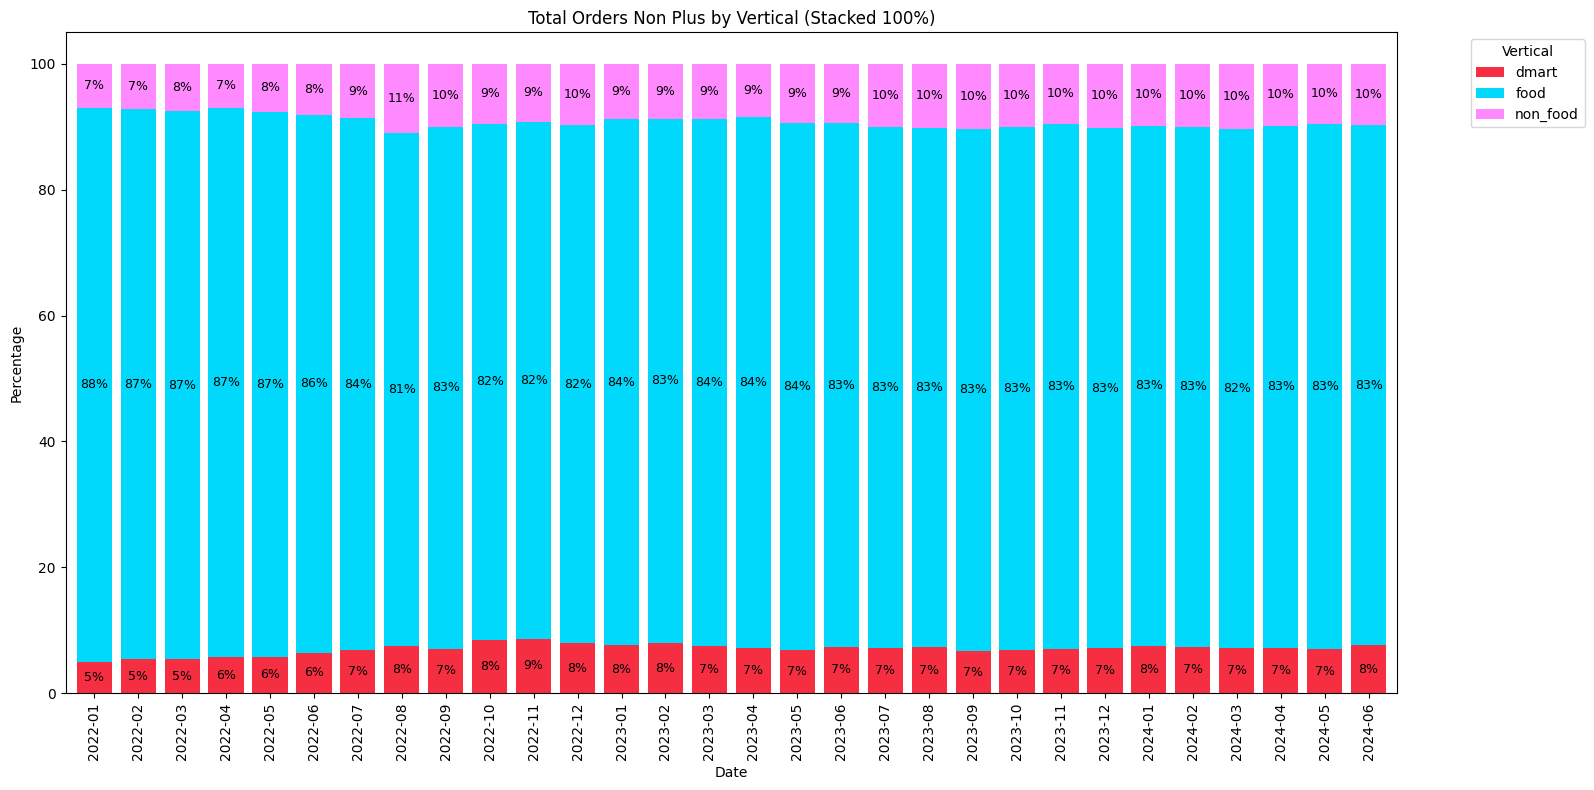

,dmart,food,non_food,dmart_percentage,food_percentage,non_food_percentage
date_month,,,,,,
2022-01,112662,1989565,159373,4.981518,87.971569,7.046914
2022-02,115875,1869285,154860,5.414669,87.348950,7.236381
2022-03,122919,1972556,171792,5.421461,87.001487,7.577052
2022-04,125283,1922208,154874,5.688567,87.279266,7.032168
2022-05,137892,2066405,183030,5.776000,86.557267,7.666734
2022-06,146325,1952225,184162,6.410138,85.522177,8.067684
2022-07,159351,1960653,200974,6.865683,84.475294,8.659022
2022-08,167350,1802453,244098,7.559055,81.415248,11.025696
2022-09,142227,1677553,202764,7.032084,82.942720,10.025196


In [155]:
# Filtrar los datos para tener solo las filas donde 'date_month' es mayor a '2022-01' que fue cuando comenzo el programa

filtered_data = vertical_monthly_sales[vertical_monthly_sales['date_month'] >= pd.Period('2022-01', freq='M')]

# Pivotar los datos para tener 'date_month' como índice y 'vertical' como columnas
pivot_data = filtered_data.pivot(index='date_month', columns='vertical', values='total_orders_non_plus')


## Normalizar los datos para obtener porcentajes
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Crear el gráfico de barras apiladas al 100%
ax = pivot_data_percentage.plot(kind='bar', stacked=True, color=colors, figsize=(16, 8), width=0.8,)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('Total Orders Non Plus by Vertical (Stacked 100%)')
plt.legend(title='Vertical', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadir los porcentajes en cada Vertical del gráfico
for n, x in enumerate([*pivot_data_percentage.index.values]):
    for (proportion, y_loc) in zip(pivot_data_percentage.loc[x], (pivot_data_percentage.cumsum(axis=1).loc[x] - pivot_data_percentage.loc[x] / 2)):
        if proportion > 0:
            ax.text(n, y_loc, f'{proportion:.0f}%', ha='center', va='center', color='black', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Crear una tabla con la visibilidad de las órdenes por vertical y el porcentaje que representa en cada mes
visibility_table = pivot_data_percentage.copy()
visibility_table.columns = [f'{col}_percentage' for col in visibility_table.columns]

# Unir las tablas para tener las órdenes y los porcentajes juntos
combined_table = pivot_data.join(visibility_table)

# Mostrar la tabla en Google Colab
combined_table

Ahora calcularemos la frecuencia y afv del 2024 por vertical. agruparemos los datos para no verlo como serie temporal.

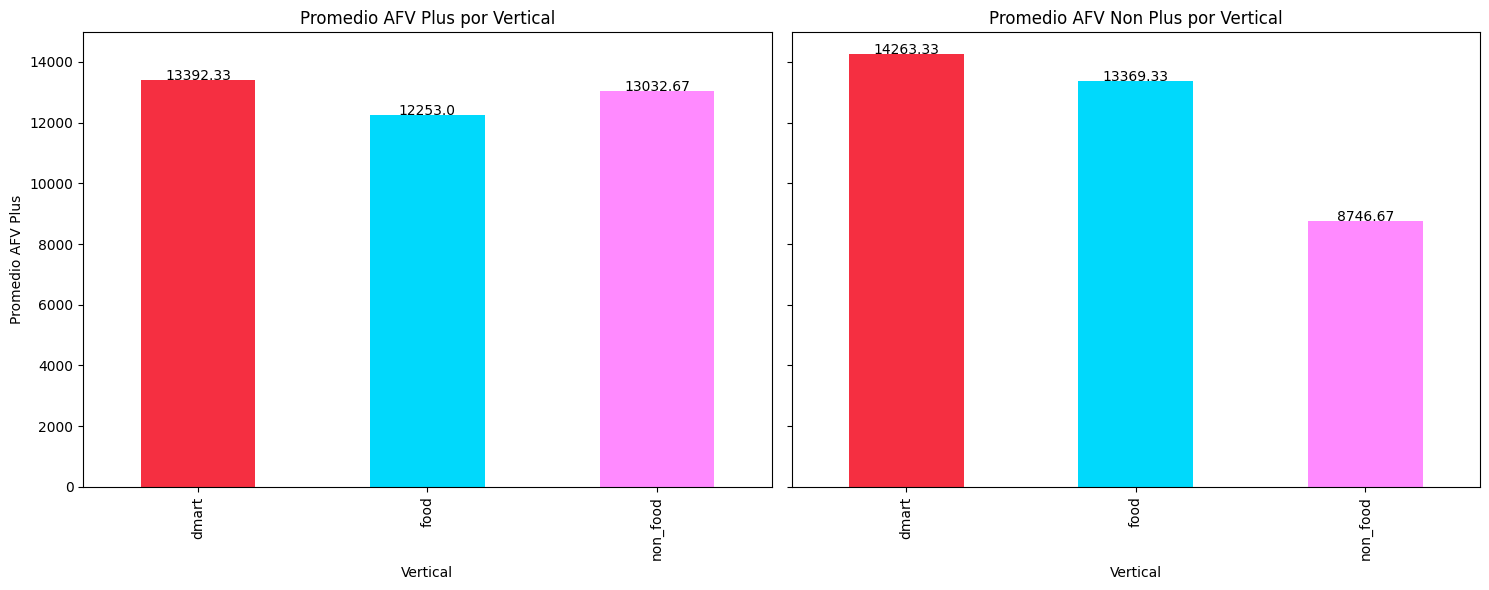

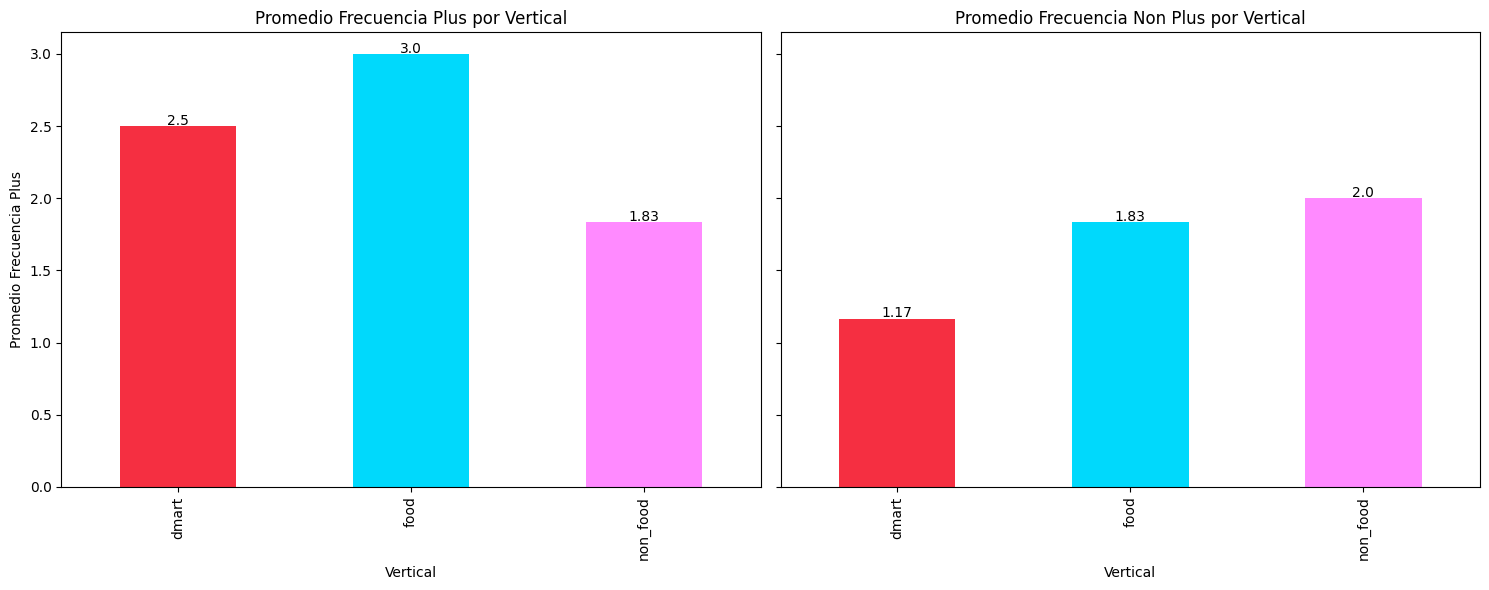

In [153]:
# Filtrar el DataFrame desde enero 2024 en adelante

df_filtered= vertical_monthly_sales[vertical_monthly_sales['date_month'] >= pd.Period('2024-01', freq='M')]
df_filtered = df_filtered[df_filtered['vertical'] != 'other']


# Crear el gráfico de barras para total_afv_plus y total_afv_non_plus por vertical
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Total afv plus
df_grouped_plus = df_filtered.groupby('vertical')['total_afv_plus'].mean()
df_grouped_plus.plot(kind='bar', ax=ax[0], color=colors)
ax[0].set_title('Promedio AFV Plus por Vertical')
ax[0].set_xlabel('Vertical')
ax[0].set_ylabel('Promedio AFV Plus')
for i in ax[0].patches:
    ax[0].text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center', color='black')

# Total afv non plus
df_grouped_non_plus = df_filtered.groupby('vertical')['total_afv_non_plus'].mean()
df_grouped_non_plus.plot(kind='bar', ax=ax[1], color=colors)
ax[1].set_title('Promedio AFV Non Plus por Vertical')
ax[1].set_xlabel('Vertical')
for i in ax[1].patches:
    ax[1].text(i.get_x() + i.get_width() / 2, i.get_height() + 0., round(i.get_height(), 2), ha='center', color='black')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Crear el gráfico de barras para total_frequency_plus y total_frequency_non_plus por Vertical
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Total frequency plus
df_grouped_frequency_plus = df_filtered.groupby('vertical')['total_frequency_plus'].mean()
df_grouped_frequency_plus.plot(kind='bar', ax=ax[0], color=colors)
ax[0].set_title('Promedio Frecuencia Plus por Vertical')
ax[0].set_xlabel('Vertical')
ax[0].set_ylabel('Promedio Frecuencia Plus')
for i in ax[0].patches:
    ax[0].text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center', color='black')

# Total frequency non plus
df_grouped_frequency_non_plus = df_filtered.groupby('vertical')['total_frequency_non_plus'].mean()
df_grouped_frequency_non_plus.plot(kind='bar', ax=ax[1], color=colors)
ax[1].set_title('Promedio Frecuencia Non Plus por Vertical')
ax[1].set_xlabel('Vertical')
for i in ax[1].patches:
    ax[1].text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center', color='black')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Segunda Conclusión de las verticales.Lo primero que observamos es que existe una mayor penetración en la vertical DMART. Esto quiere decir que los usuarios piden más en el market propio que los usuarios no p lus por casi el doble en desmedro de food.
Por lo que podemos concluir que probablemente sean premium o plus por la razón de que hacen pedidos a supermercado más seguido. Y necesitan un descuento en envios y otros productos.

Lo primero que notamos cuando revisamos AFV es que la dmart sigue liderando tanto en Plus y No plus. Debido a que son pedidos de supermercado. Mientras que en terminos de food vemos que los usuarios plus tienen un menor valor posiblemente por la promocionalidad a la que tienen acceso por ser plus. Mientras que vemos una gra diferencia de afv en non_food. Ya que en non_food estan incluidos otros supermercados y carnicerrias botillerias a las cuales los usuarios plus pueden pedir más.

Finalmente en termino de frecuencia vemos efectivamente que los no plus piden menos a supermercado y casi al mismo. nivel de frecuencia en non_food.
Mientras que en food notamos casi el doble de pedidos para los usurios plus. Quienes deben pedir más por la promocionalidad.

Ahora que ya hemos visto un resumen de como funciona el programa de incentivo Plus. Pasaremos a realizar los analisis de predicción. de ventos mensuales para el resto del año.

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.ticker import PercentFormatter
from google.colab import drive
from google.colab import data_table

# Montar Google Drive
drive.mount('/content/drive')

# Definir la ruta del archivo
file_path = '/content/drive/My Drive/CODERHOUSE_Rigoberto_Olivares/proyecto_ds_01/bbdd_mensual.xlsx'

# Cargar los datos
df = pd.read_excel(file_path)

# Asegurarse de que date_month sea de tipo datetime
df['date_month'] = pd.to_datetime(df['date_month'])

# Filtrar los datos para que solo incluyan fechas entre 2021-01-01 y 2024-05-01
df = df[(df['date_month'] >= '2021-01-01') & (df['date_month'] <= '2024-05-01')]
# Establecer la columna date_month como índice
df.set_index('date_month', inplace=True)

# Llenar los valores faltantes usando interpolación lineal
df['total_confirmed_order'] = df['total_confirmed_order'].interpolate(method='linear')

# Asegurarse de que los datos sean mensuales sin introducir NaN
df = df.resample('M').mean()

# Verificar si todavía hay valores faltantes y llenarlos si es necesario
if df['total_confirmed_order'].isnull().any():
    df['total_confirmed_order'] = df['total_confirmed_order'].fillna(method='ffill')
print(df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
            total_confirmed_order
date_month                       
2021-01-31              2048754.0
2021-02-28              1857831.0
2021-03-31              2244244.0
2021-04-30              2298036.0
2021-05-31              2543398.0
2021-06-30              2460558.0
2021-07-31              2520489.0
2021-08-31              2421862.0
2021-09-30              2179795.0
2021-10-31              2388619.0
2021-11-30              2244495.0
2021-12-31              2260223.0
2022-01-31              2262223.0
2022-02-28              2142470.0
2022-03-31              2271342.0
2022-04-30              2208143.0
2022-05-31              2395909.0
2022-06-30              2294814.0
2022-07-31              2335390.0
2022-08-31              2230575.0
2022-09-30              2050905.0
2022-10-31              2186657.0
2022-11-30              1981830.0
2022-12-31           

Comenzamos con una descomposición de nuestra seriel temporal para ver que modelo elegir. Para eso evaluaremos componentes tendenciales, estacionales y residuales.

Valores faltantes antes de seasonal_decompose: date_month               0
total_confirmed_order    0
dtype: int64


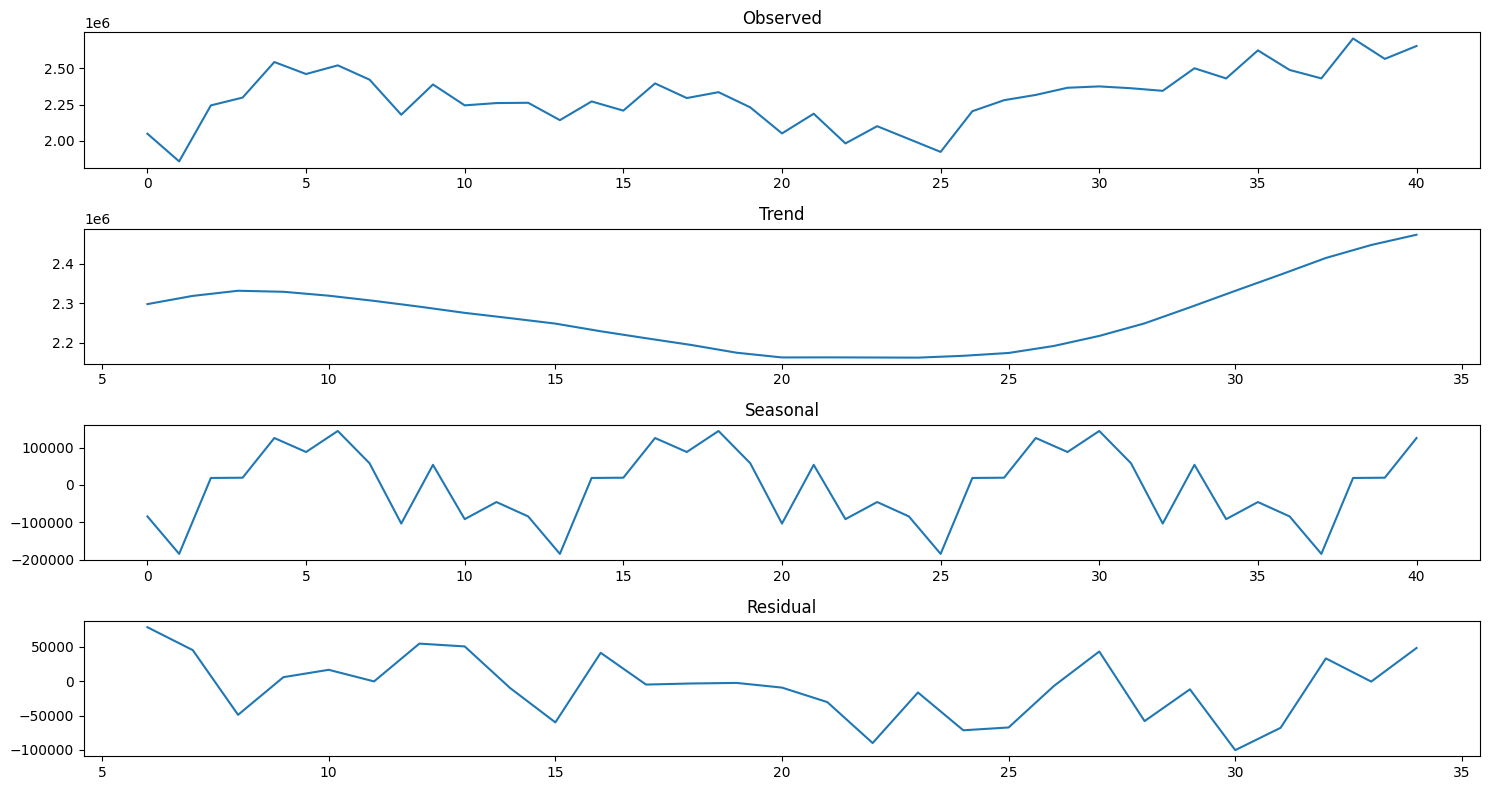

Trend Component:
 6     2.297920e+06
7     2.318674e+06
8     2.331663e+06
9     2.329047e+06
10    2.319156e+06
Name: trend, dtype: float64
Seasonal Component:
 0    -83897.082755
1   -183856.041088
2     18741.917245
3     19409.708912
4    125333.313079
Name: seasonal, dtype: float64
Residual Component:
 6     78462.811921
7     45165.048032
8    -48963.063079
9      5819.631366
10    16537.367477
Name: resid, dtype: float64


In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Definir la ruta del archivo
file_path = '/content/drive/My Drive/CODERHOUSE_Rigoberto_Olivares/proyecto_ds_01/bbdd_mensual.xlsx'


# Cargar los datos
df = pd.read_excel(file_path)

# Asegurarse de que date_month sea de tipo datetime
df['date_month'] = pd.to_datetime(df['date_month'])

# Filtrar los datos para que solo incluyan fechas entre 2021-01-01 y 2024-05-01
df = df[(df['date_month'] >= '2021-01-01') & (df['date_month'] <= '2024-05-01')]

# Llenar los valores faltantes
df['total_confirmed_order'] = df['total_confirmed_order'].interpolate(method='linear')

# Verificar si todavía hay valores faltantes y llenarlos si es necesario
if df['total_confirmed_order'].isnull().any():
    df['total_confirmed_order'] = df['total_confirmed_order'].fillna(method='ffill')  # Forward fill any remaining NaNs

# Verificar si todavía hay valores faltantes
print("Valores faltantes antes de seasonal_decompose:", df.isnull().sum())

# Extraer la serie temporal de las ventas
ts = df['total_confirmed_order']

# Descomponer la serie temporal
decomposition = seasonal_decompose(ts, model='additive', period=12)

# Graficar la descomposición
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

# Imprimir los componentes
print("Trend Component:\n", decomposition.trend.dropna().head())
print("Seasonal Component:\n", decomposition.seasonal.dropna().head())
print("Residual Component:\n", decomposition.resid.dropna().head())

Entonces para seleccionar los modelos que vamos a utilizar para las predicciones analizaremos la descomposición.

1.   Componente de Tendencia: Observamos una tendencia ligeramente descendente hasta mediados de 2023, seguida de una recuperación hacia principios de 2024. Esto inos puede estar indicando que aparte de las fluctuaciones estacionales, hay una tendencia general en nuestra serie temporal de ordenes.

2.   Componente de Estacinoalidad: Logramos ver patrones repetitivos que se repiten anualmente. Podemos ver variaciones que indican que hay meses específicos en los que los pedidos tienden a aumentar o disminuir de manera regular cada año. Esto puede deberse a que el negocio del delivery depende de epoca especificas del año como inviernos de mayor demanda producto las lluvias.

3. Componente Residual: Este muestra ruido en la serie. Que no se explica necesarimente por la tendencia o la estacionalidad, esta puede deberse a eventos aleatorios como protestas en el pais o paro de los repartidores. Errores en la logistica, etc.





Basándonos en la descomposición y en la necesidad de capturar tanto la tendencia como la estacionalidad, aquí están los tres modelos de series temporales recomendados:

1.   Modelo ARIMA (Autoregressive Integrated Moving Average): Este modelo es adecuado para series temporales que muestran tendencia y patrones estacionales
2.   Modelo SARIMA (Seasonal ARIMA):Este es una extensión del ARIMA que incluye componentes estacionales, lo cual es crucial dado que hemos identificado un patrón estacional en nuestros datos.
3. Modelo Holt-Winters (Triple Exponential Smoothing):Este modelo es especialmente útil para datos con tendencia y estacionalidad.






Datos completos:


,total_confirmed_order
date_month,
2021-01-31,2048754.0
2021-02-28,1857831.0
2021-03-31,2244244.0
2021-04-30,2298036.0
2021-05-31,2543398.0
2021-06-30,2460558.0
2021-07-31,2520489.0
2021-08-31,2421862.0
2021-09-30,2179795.0


Datos de entrenamiento:


,total_confirmed_order
date_month,
2021-01-31,2048754.0
2021-02-28,1857831.0
2021-03-31,2244244.0
2021-04-30,2298036.0
2021-05-31,2543398.0
2021-06-30,2460558.0
2021-07-31,2520489.0
2021-08-31,2421862.0
2021-09-30,2179795.0


Datos de prueba:


,total_confirmed_order
date_month,
2024-01-31,2488726.0
2024-02-29,2430520.0
2024-03-31,2705950.0
2024-04-30,2565035.0
2024-05-31,2653930.0


Predicciones ARIMA:


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,total_confirmed_order,ARIMA Forecast
date_month,,
2024-01-31,2488726.0,2.586720e+06
2024-02-29,2430520.0,2.632789e+06
2024-03-31,2705950.0,2.622279e+06
2024-04-30,2565035.0,2.635301e+06
2024-05-31,2653930.0,2.623435e+06


ARIMA Mean Squared Error: 12676725485.439651


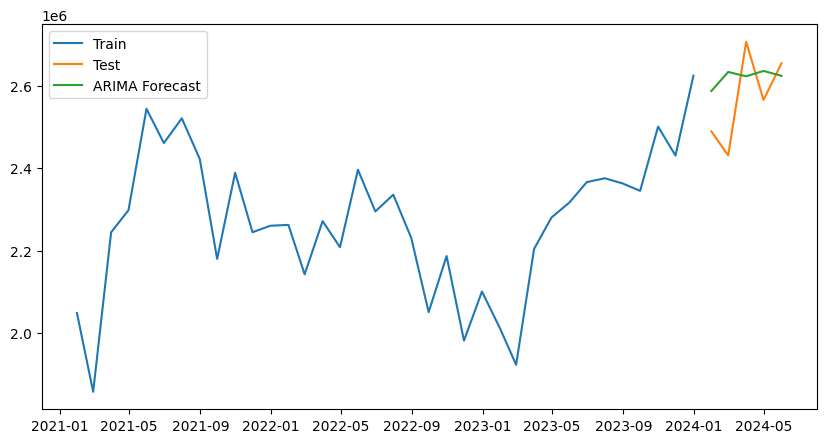

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from IPython.display import display

# Definir la ruta del archivo
file_path = '/content/drive/My Drive/CODERHOUSE_Rigoberto_Olivares/proyecto_ds_01/bbdd_mensual.xlsx'

# Cargar los datos
df = pd.read_excel(file_path)

# Asegurarse de que date_month sea de tipo datetime
df['date_month'] = pd.to_datetime(df['date_month'])

# Filtrar los datos para que solo incluyan fechas entre 2021-01-01 y 2024-05-01
df = df[(df['date_month'] >= '2021-01-01') & (df['date_month'] <= '2024-05-01')]

# Establecer la columna date_month como índice
df.set_index('date_month', inplace=True)

# Llenar los valores faltantes usando interpolación lineal
df['total_confirmed_order'] = df['total_confirmed_order'].interpolate(method='linear')

# Asegurarse de que los datos sean mensuales sin introducir NaN
df = df.resample('M').mean()

# Verificar si todavía hay valores faltantes y llenarlos si es necesario
if df['total_confirmed_order'].isnull().any():
    df['total_confirmed_order'] = df['total_confirmed_order'].fillna(method='ffill')  # Forward fill any remaining NaNs

# Mostrar los datos completos
print("Datos completos:")
display(df)

# Dividir los datos en entrenamiento y prueba
train_data = df[:'2023-12']
test_data = df['2024-01':]

# Mostrar los datos de entrenamiento y prueba
print("Datos de entrenamiento:")
display(train_data)
print("Datos de prueba:")
display(test_data)

# Ajustar el modelo ARIMA
model_arima = ARIMA(train_data['total_confirmed_order'], order=(5,1,2))
model_arima_fit = model_arima.fit()

# Predicciones
arima_forecast = model_arima_fit.forecast(steps=len(test_data))

# Crear un DataFrame para mostrar las predicciones junto con los datos de prueba
arima_results = test_data.copy()
arima_results['ARIMA Forecast'] = arima_forecast

# Mostrar las predicciones
print("Predicciones ARIMA:")
display(arima_results)

# Evaluar el modelo
arima_mse = mean_squared_error(test_data['total_confirmed_order'], arima_forecast)
print(f'ARIMA Mean Squared Error: {arima_mse}')

# Graficar las predicciones
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data['total_confirmed_order'], label='Train')
plt.plot(test_data.index, test_data['total_confirmed_order'], label='Test')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()






/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Predicciones SARIMA:


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,total_confirmed_order,SARIMA Forecast
date_month,,
2024-01-31,2488726.0,2.595373e+06
2024-02-29,2430520.0,2.503290e+06
2024-03-31,2705950.0,2.796070e+06
2024-04-30,2565035.0,2.876964e+06
2024-05-31,2653930.0,2.915533e+06


SARIMA Mean Squared Error: 38105258117.118126


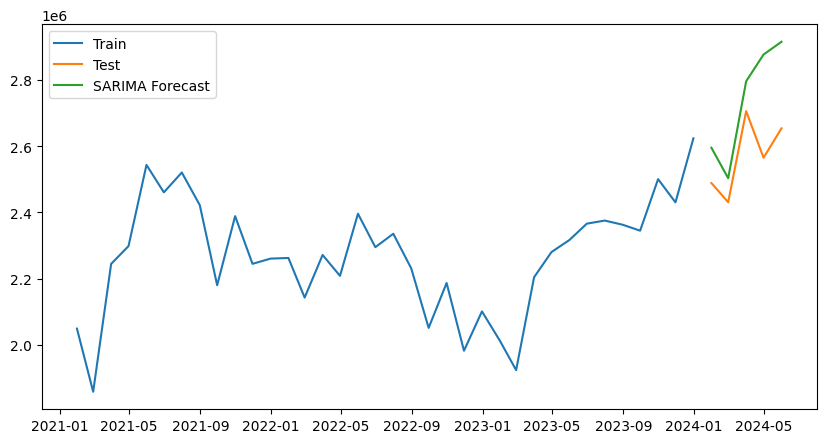

In [235]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA
model_sarima = SARIMAX(train_data['total_confirmed_order'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()

# Predicciones
sarima_forecast = model_sarima_fit.forecast(steps=len(test_data))

# Crear un DataFrame para mostrar las predicciones junto con los datos de prueba
sarima_results = test_data.copy()
sarima_results['SARIMA Forecast'] = sarima_forecast

# Mostrar las predicciones
print("Predicciones SARIMA:")
display(sarima_results)

# Evaluar el modelo
sarima_mse = mean_squared_error(test_data['total_confirmed_order'], sarima_forecast)
print(f'SARIMA Mean Squared Error: {sarima_mse}')

# Graficar las predicciones
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data['total_confirmed_order'], label='Train')
plt.plot(test_data.index, test_data['total_confirmed_order'], label='Test')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.show()




Predicciones Holt-Winters:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,total_confirmed_order,Holt-Winters Forecast
date_month,,
2024-01-31,2488726.0,2.584778e+06
2024-02-29,2430520.0,2.484831e+06
2024-03-31,2705950.0,2.687457e+06
2024-04-30,2565035.0,2.688113e+06
2024-05-31,2653930.0,2.794045e+06


Holt-Winters Mean Squared Error: 9459632928.908209


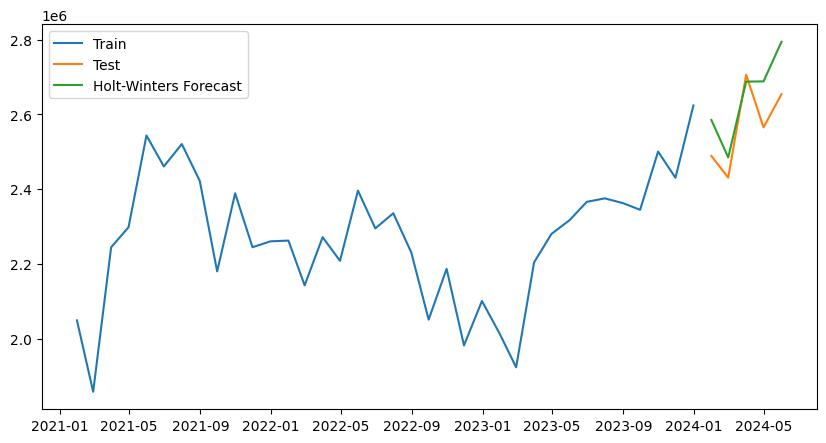

In [236]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar el modelo Holt-Winters
model_hw = ExponentialSmoothing(train_data['total_confirmed_order'], seasonal='add', seasonal_periods=12)
model_hw_fit = model_hw.fit()

# Predicciones
hw_forecast = model_hw_fit.forecast(steps=len(test_data))

# Crear un DataFrame para mostrar las predicciones junto con los datos de prueba
hw_results = test_data.copy()
hw_results['Holt-Winters Forecast'] = hw_forecast

# Mostrar las predicciones
print("Predicciones Holt-Winters:")
display(hw_results)

# Evaluar el modelo
hw_mse = mean_squared_error(test_data['total_confirmed_order'], hw_forecast)
print(f'Holt-Winters Mean Squared Error: {hw_mse}')

# Graficar las predicciones
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data['total_confirmed_order'], label='Train')
plt.plot(test_data.index, test_data['total_confirmed_order'], label='Test')
plt.plot(test_data.index, hw_forecast, label='Holt-Winters Forecast')
plt.legend()
plt.show()



In [237]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Comparar ARIMA
arima_mse = mean_squared_error(test_data['total_confirmed_order'], arima_forecast)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data['total_confirmed_order'], arima_forecast)
arima_mape = mean_absolute_percentage_error(test_data['total_confirmed_order'], arima_forecast)

print(f'ARIMA Mean Squared Error: {arima_mse}')
print(f'ARIMA Root Mean Squared Error: {arima_rmse}')
print(f'ARIMA Mean Absolute Error: {arima_mae}')
print(f'ARIMA Mean Absolute Percentage Error: {arima_mape}%')

# Comparar SARIMA
sarima_mse = mean_squared_error(test_data['total_confirmed_order'], sarima_forecast)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(test_data['total_confirmed_order'], sarima_forecast)
sarima_mape = mean_absolute_percentage_error(test_data['total_confirmed_order'], sarima_forecast)

print(f'SARIMA Mean Squared Error: {sarima_mse}')
print(f'SARIMA Root Mean Squared Error: {sarima_rmse}')
print(f'SARIMA Mean Absolute Error: {sarima_mae}')
print(f'SARIMA Mean Absolute Percentage Error: {sarima_mape}%')

# Comparar Holt-Winters
hw_mse = mean_squared_error(test_data['total_confirmed_order'], hw_forecast)
hw_rmse = np.sqrt(hw_mse)
hw_mae = mean_absolute_error(test_data['total_confirmed_order'], hw_forecast)
hw_mape = mean_absolute_percentage_error(test_data['total_confirmed_order'], hw_forecast)

print(f'Holt-Winters Mean Squared Error: {hw_mse}')
print(f'Holt-Winters Root Mean Squared Error: {hw_rmse}')
print(f'Holt-Winters Mean Absolute Error: {hw_mae}')
print(f'Holt-Winters Mean Absolute Percentage Error: {hw_mape}%')

# Resumen de resultados en una tabla
results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Holt-Winters'],
    'MSE': [arima_mse, sarima_mse, hw_mse],
    'RMSE': [arima_rmse, sarima_rmse, hw_rmse],
    'MAE': [arima_mae, sarima_mae, hw_mae],
    'MAPE (%)': [arima_mape, sarima_mape, hw_mape]
})

print("\nComparación de Modelos:")
display(results)


ARIMA Mean Squared Error: 12676725485.439651
ARIMA Root Mean Squared Error: 112590.96538106266
ARIMA Mean Absolute Error: 96939.1084080833
ARIMA Mean Absolute Percentage Error: 3.8480244799748466%
SARIMA Mean Squared Error: 38105258117.118126
SARIMA Root Mean Squared Error: 195205.6815697692
SARIMA Mean Absolute Error: 168613.6532119195
SARIMA Mean Absolute Percentage Error: 6.5255250567952565%
Holt-Winters Mean Squared Error: 9459632928.908209
Holt-Winters Root Mean Squared Error: 97260.6442961808
Holt-Winters Mean Absolute Error: 86409.76239979286
Holt-Winters Mean Absolute Percentage Error: 3.3710531537496244%

Comparación de Modelos:


,Model,MSE,RMSE,MAE,MAPE (%)
0,ARIMA,1.267673e+10,112590.965381,96939.108408,3.848024
1,SARIMA,3.810526e+10,195205.681570,168613.653212,6.525525
2,Holt-Winters,9.459633e+09,97260.644296,86409.762400,3.371053


Basados en la comparación de los modelos y sin llegar a mejorarlos. Es decir optimizando las componentes por ejemplo en arima y sarima. Decidimos continuar con el modelo Holt-Winters ya que presenta menor MAPE, lo que nos indica que el error relativo del modelo es menor que la de los otros dos.

Tambien vemos un menor MSE y RMSE indicando que los errores de predicion son menores al los dotros dos y finalmnete porque MAE tambien es menor lo que nos indica que en promedio el modelo esta mas cercano a los datos reales.

Por tanto estos serian muestros pronosticos


Pronóstico para los próximos 2 meses (incluyendo junio 2024):


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Forecast
2024-05-31,2.604190e+06
2024-06-30,2.690744e+06


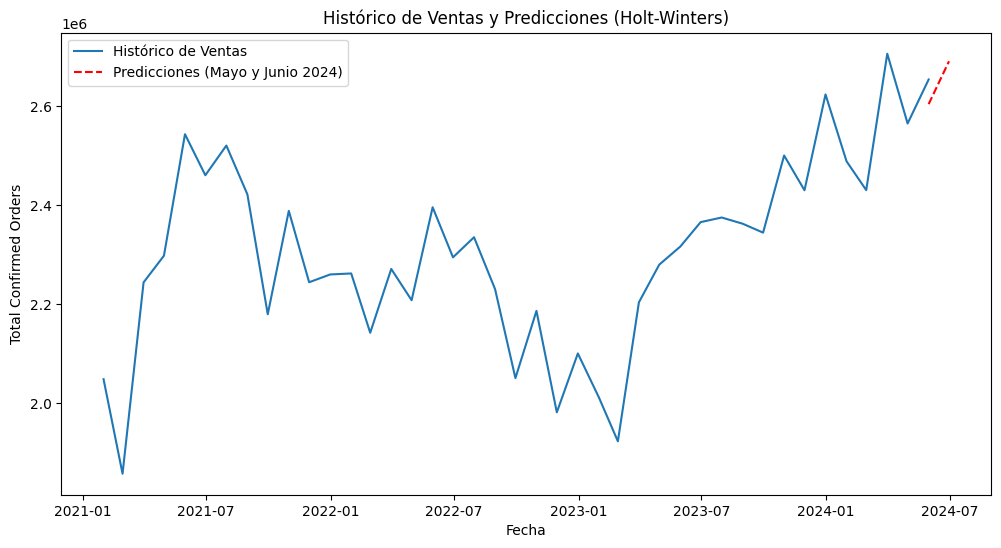

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display

# Definir la ruta del archivo
file_path = '/content/drive/My Drive/CODERHOUSE_Rigoberto_Olivares/proyecto_ds_01/bbdd_mensual.xlsx'

# Cargar los datos
df = pd.read_excel(file_path)

# Asegurarse de que date_month sea de tipo datetime
df['date_month'] = pd.to_datetime(df['date_month'])

# Filtrar los datos para que solo incluyan fechas entre 2021-01-01 y 2024-05-01
df = df[(df['date_month'] >= '2021-01-01') & (df['date_month'] <= '2024-05-01')]

# Establecer la columna date_month como índice
df.set_index('date_month', inplace=True)

# Llenar los valores faltantes usando interpolación lineal
df['total_confirmed_order'] = df['total_confirmed_order'].interpolate(method='linear')

# Asegurarse de que los datos sean mensuales sin introducir NaN
df = df.resample('M').mean()

# Ajustar el modelo Holt-Winters con parámetros optimizados usando todos los datos disponibles
model_hw_opt_full = ExponentialSmoothing(df['total_confirmed_order'], trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)

# Predicciones extendidas para 2 meses adicionales (mayo y junio 2024)
extended_forecast = model_hw_opt_full.forecast(steps=2)  # Predecimos los próximos 2 meses

# Crear un DataFrame para mostrar las predicciones
extended_forecast_df = pd.DataFrame(extended_forecast, columns=['Forecast'])
extended_forecast_df.index = pd.date_range(start='2024-05-01', periods=2, freq='M')  # Ajustar las fechas de índice al final del mes

# Mostrar las predicciones
print("Pronóstico para los próximos 2 meses (incluyendo junio 2024):")
display(extended_forecast_df)

# Graficar el histórico incluyendo las nuevas predicciones
plt.figure(figsize=(12,6))
plt.plot(df.index, df['total_confirmed_order'], label='Histórico de Ventas')
plt.plot(extended_forecast_df.index, extended_forecast_df['Forecast'], label='Predicciones (Mayo y Junio 2024)', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Total Confirmed Orders')
plt.title('Histórico de Ventas y Predicciones (Holt-Winters)')
plt.legend()
plt.show()
